# 1. Libraries

In [239]:
# manipulation
import numpy as np
import pandas as pd
from statsmodels import tsa
from toolz import pipe, thread_first
from functools import reduce
from utils.data_access import DataAccess
import datetime as dt
import warnings
warnings.filterwarnings("ignore")
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

# data visualization
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['seaborn', 'seaborn-whitegrid'])
%config InlineBackend.figure_format = 'retina'

# analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# algorithms
from sktime.forecasting.arima import ARIMA, AutoARIMA
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.compose import AutoEnsembleForecaster
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HW
from statsmodels.tsa.exponential_smoothing.ets import ETSModel as ETS

# evaluation
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error as MSE, mean_absolute_error as MAE, r2_score as R2

# 2. Read data

In [3]:
# connection
conn = DataAccess()
query = '''
SELECT accounting_date, action, SUM(cash_value) AS cash_value
FROM (
    SELECT action
           , [cash_value]
           , [status]
           , CAST(ISNULL(accounting_time, updated_at) AS date) AS accounting_date
    FROM (
        SELECT *, CASE WHEN DATEPART(h, success_time) < 7 THEN DATEADD(D, -1, CAST(success_time AS date)) ELSE success_time END AS accounting_time
        FROM [stg_isave_isave_transaction]) a
        WHERE status = 'DONE')
GROUP BY accounting_date, action
HAVING accounting_date BETWEEN '2021-09-01' AND current_date - 1
ORDER BY accounting_date;
'''

dfTrans = conn.executeQuery('tcbs_dwh', query)
dfTrans = dfTrans.rename(columns={'accounting_date': 'date'})
dfTrans = dfTrans.pivot(index='date', columns='action', values='cash_value').rename_axis(None, axis=1)
dfTrans.columns = dfTrans.columns.str.lower().str.replace('isave_', '')
dfTrans = dfTrans[['withdraw']]
dfTrans = dfTrans.asfreq('d').fillna(1e-6)
series = dfTrans.withdraw

# 4. Develop AutoForecast

## 4.1. Models
**ARIMA** (AutoRegressive Integrated Moving Average) is an statistical model aiming to demonstrate the auto-correlations in time series data. The term auto means we are examining the relationship between our series with historical versions of itself (lagged series). Variants
- *Sesonal ARIMA*
- *ARIMAX*

**ETS** (Error, Trend and Seasonal) is the state-space form of Holt-Winters' method, which adds seasonality and trend to the simple exponetial smoothing model. The naive method assumes that only most recent observations are the most important ones. Variants:
- *Holt-Winters*
- *Exponential Smoothing*

## 4.2. Approach
**Traing**
```
|----------------------------------------------------------------------|----------|          |
|                              train data                              |   test   | forecast |
```

**Error analysis**
```
|----------------------------------|----------|----------|------------------------|
|             training             |   test   | forecast |

|------------------|----------|----------|----------------------------------------|
|     training     |   test   | forecast |
```

In [131]:
def format_number(num, decimal=2):
    power = 0
    while True:
        base = num / 10**power
        if np.abs(base) < 1e3:
            break
        power += 3
    strBase = f'{base:.{decimal}f}'
    strPower = f'e{power}' if power > 0 else ''
    out = strBase + strPower
    return out

In [203]:
class AutoForecast():
    def __init__(self, ts, estimator='ETS', gamma=(0.95, 0.99), nTest=7, nInfer=7, forcePositive=True): 
        self.series = ts
        self.estimator = estimator.upper()
        self.nTest = nTest
        self.nInfer = nInfer
        self.gammaList = gamma
        self.forcePositive = forcePositive

        lastDay = self.series.index[-1]
        delta = (lastDay.weekday() + 1) % 7
        lastSunday = lastDay - dt.timedelta(days=delta)
        self.seriesRounded = series[:lastSunday]
        
        cutEnd = self.seriesRounded.shape[0]
        cutTest = cutEnd - self.nTest
        self.xTest = self.seriesRounded[:cutTest]
        self.yTest = self.seriesRounded[cutTest:cutEnd]
        self.horizonTest = np.arange(1, self.nTest + 1)
        self.horizonInfer = np.arange(1, self.nTest + self.nInfer + 1)
        
        start = dt.datetime.now()
        
        if self.estimator == 'ARIMA':
            model = AutoARIMA(
                test='kpss', sp=7,
                start_p=0, max_p=7, start_q=0, max_q=5, d=0, max_d=2,
                start_P=0, max_P=5, start_Q=0, max_Q=5, D=0, max_D=2,
                suppress_warnings=True,
            )
            self.model = model.fit(self.xTest)
            self.yTestPred = model.predict(self.horizonTest)
            
        if self.estimator == 'ETS':
            paramsGrid = ParameterGrid({
                'error': ['add', 'mul'],
                'trend': ['add', 'mul'],
                'seasonal': ['add', 'mul'],
                'damped_trend': [True, False],
            })

            rmseBest = np.inf
            for params in paramsGrid:
                model = AutoETS(**params, sp=self.nTest, auto=False, suppress_warnings=True).fit(self.xTest)
                yTestPred = model.predict(self.horizonTest)
                yTestPred[np.isnan(yTestPred)] = 0
                rmseTest = MSE(self.yTest, yTestPred, squared=False) / 1e9
                if rmseTest < rmseBest:
                    rmseBest = rmseTest
                    self.model = model
                    self.yTestPred = yTestPred
                    
        print(dt.datetime.now() - start)
        
    
    def forecast(self, horizon=None):
        if horizon is None:
            horizon = self.horizonInfer
        dfCi = self.model.predict_interval(horizon, coverage=self.gammaList)
        if self.forcePositive:
            dfCi = dfCi.clip(lower=0)
        dfCi.columns = [f'{bound}_{int(gamma * 100)}' for gamma in self.gammaList for bound in ['lower', 'upper']]

        dfForecast = self.model.predict(horizon).rename('forecast').to_frame()
        dfForecast = dfForecast.join(dfCi)
        dfForecast = dfForecast.join(self.series.rename('true'))
        dfForecast['run_date'] = dt.date.today()

        return dfForecast
    
    def plot(self, horizon=None):
        if horizon is None:
            horizon = self.horizonInfer
        rmse = MSE(self.yTest, self.yTestPred, squared=False)
        mae = MAE(self.yTest, self.yTestPred)
        r2 = R2(self.yTest, self.yTestPred)
        modelDetail = self.model.summary().tables[0][1][1].data
        title = f'{modelDetail} | RMSE={format_number(rmse)} | MAE={format_number(mae)} | R2={format_number(r2)}'
        
        dfForecast = self.forecast(horizon)

        fig, ax = plt.subplots(figsize=(18,6))
        ax.plot(dfForecast.true[0:self.nTest], color='teal', label='True, seen')
        ax.plot(dfForecast.true[self.nTest-1:], color='indianred', label='True, not seen')
        ax.plot(dfForecast.forecast, '--', c='grey', label='Forecast')
        for ci in self.gammaList:
            opacity = 1 - ci + 0.05
            strCi = int(ci*100)
            lower, upper = dfForecast[f'lower_{strCi}'], dfForecast[f'upper_{strCi}']
            ax.fill_between(dfForecast.index, lower, upper, color='grey', alpha=opacity, label=f'CI {strCi}%')
        ax.legend(bbox_to_anchor=(1, 0.5), loc='center left')
        ax.set_title(title, fontsize=14)
        
        plt.show()

# 5. Forecasting

## 5.1. This week

0:00:03.879183


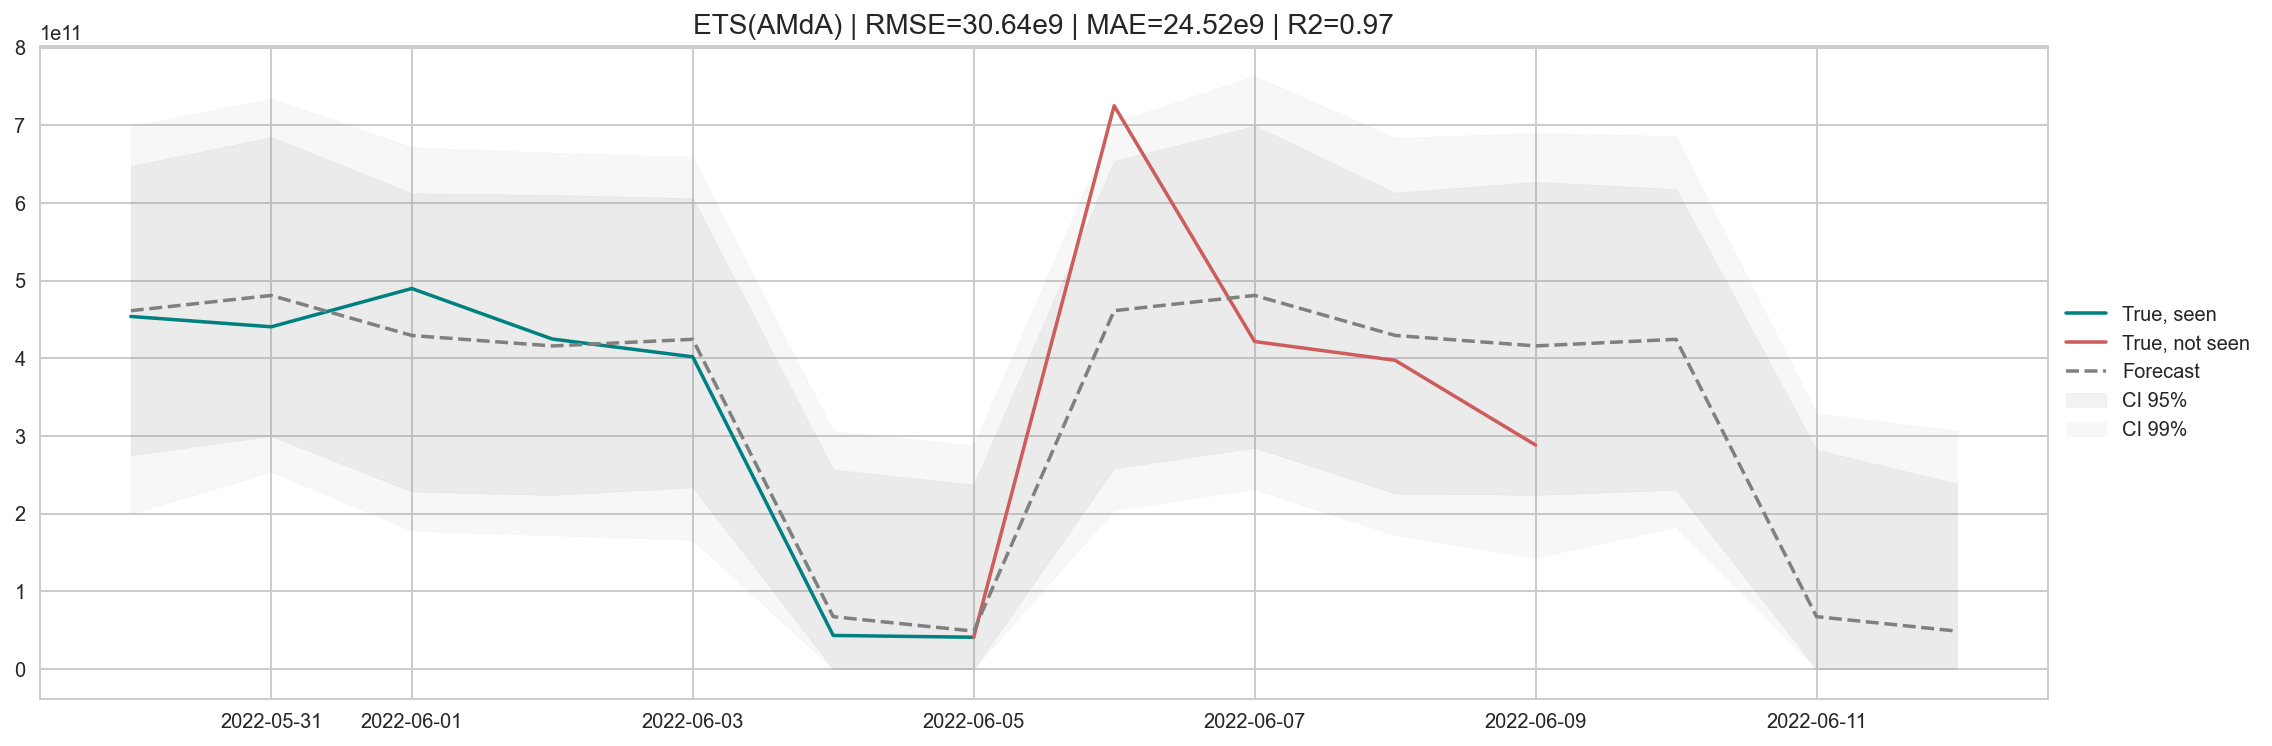

In [204]:
model = AutoForecast(ts=series, estimator='ets', nTest=7, nInfer=7, gamma=[0.95, 0.99], forcePositive=True)
model.plot()

0:00:06.517209


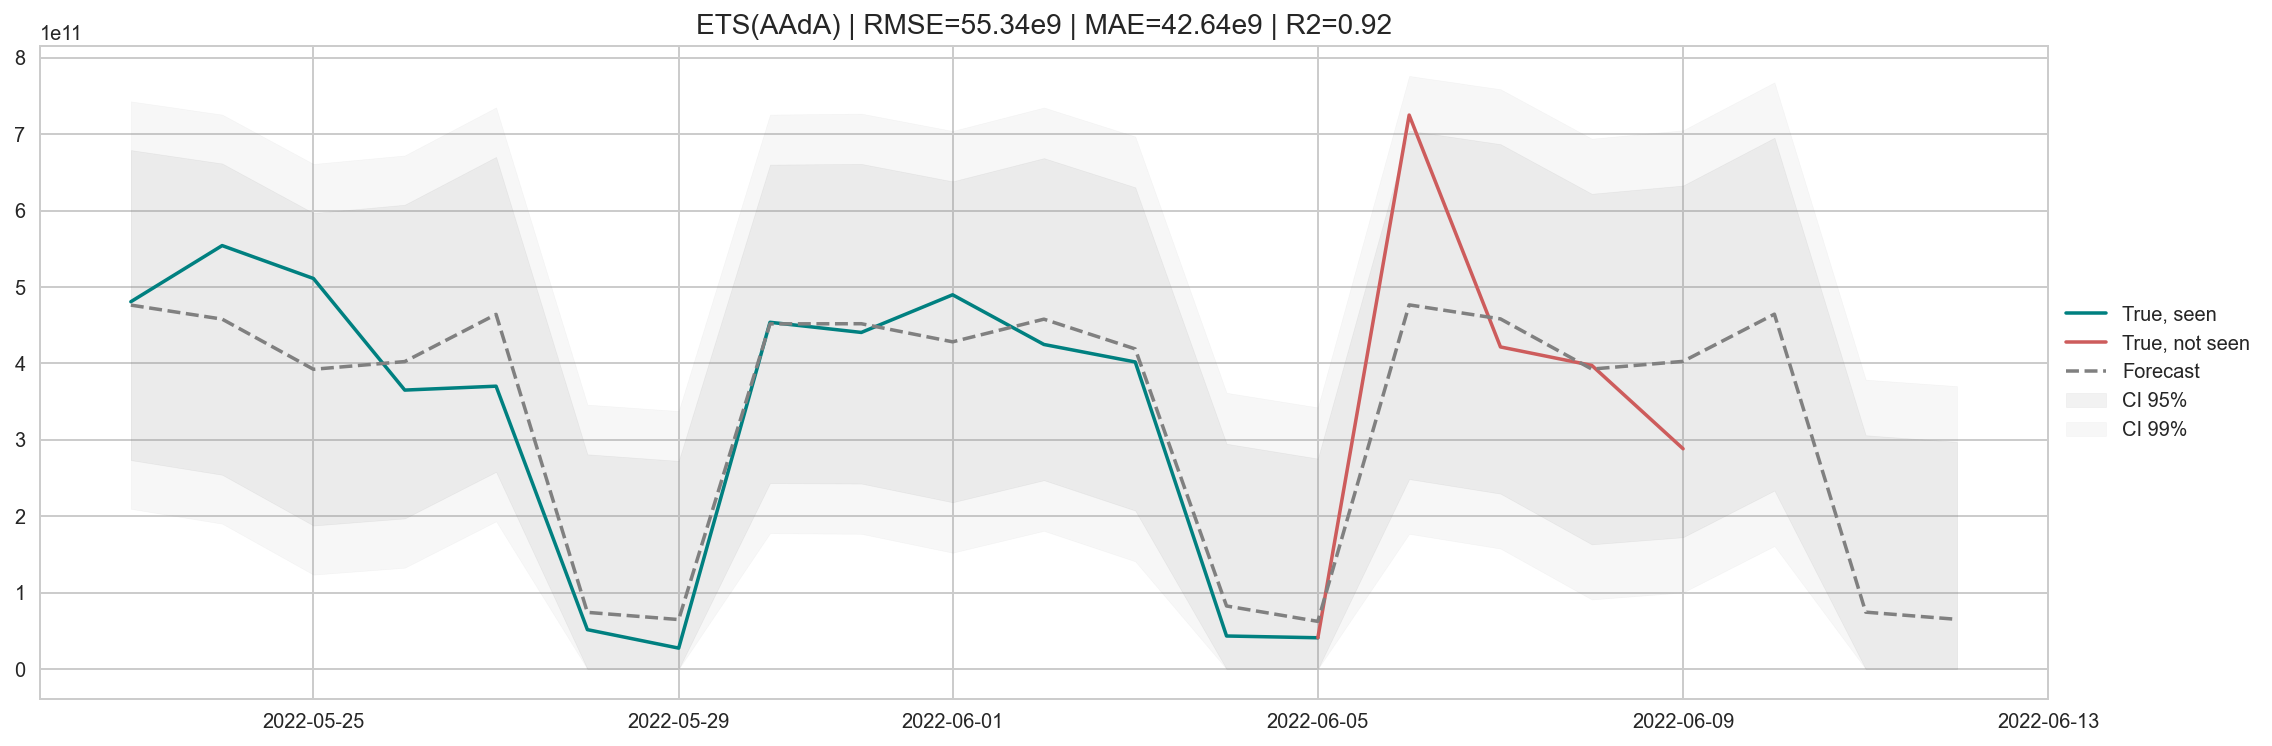

In [222]:
model = AutoForecast(ts=series, estimator='ets', nTest=14, nInfer=7)
model.plot()

0:00:04.009471


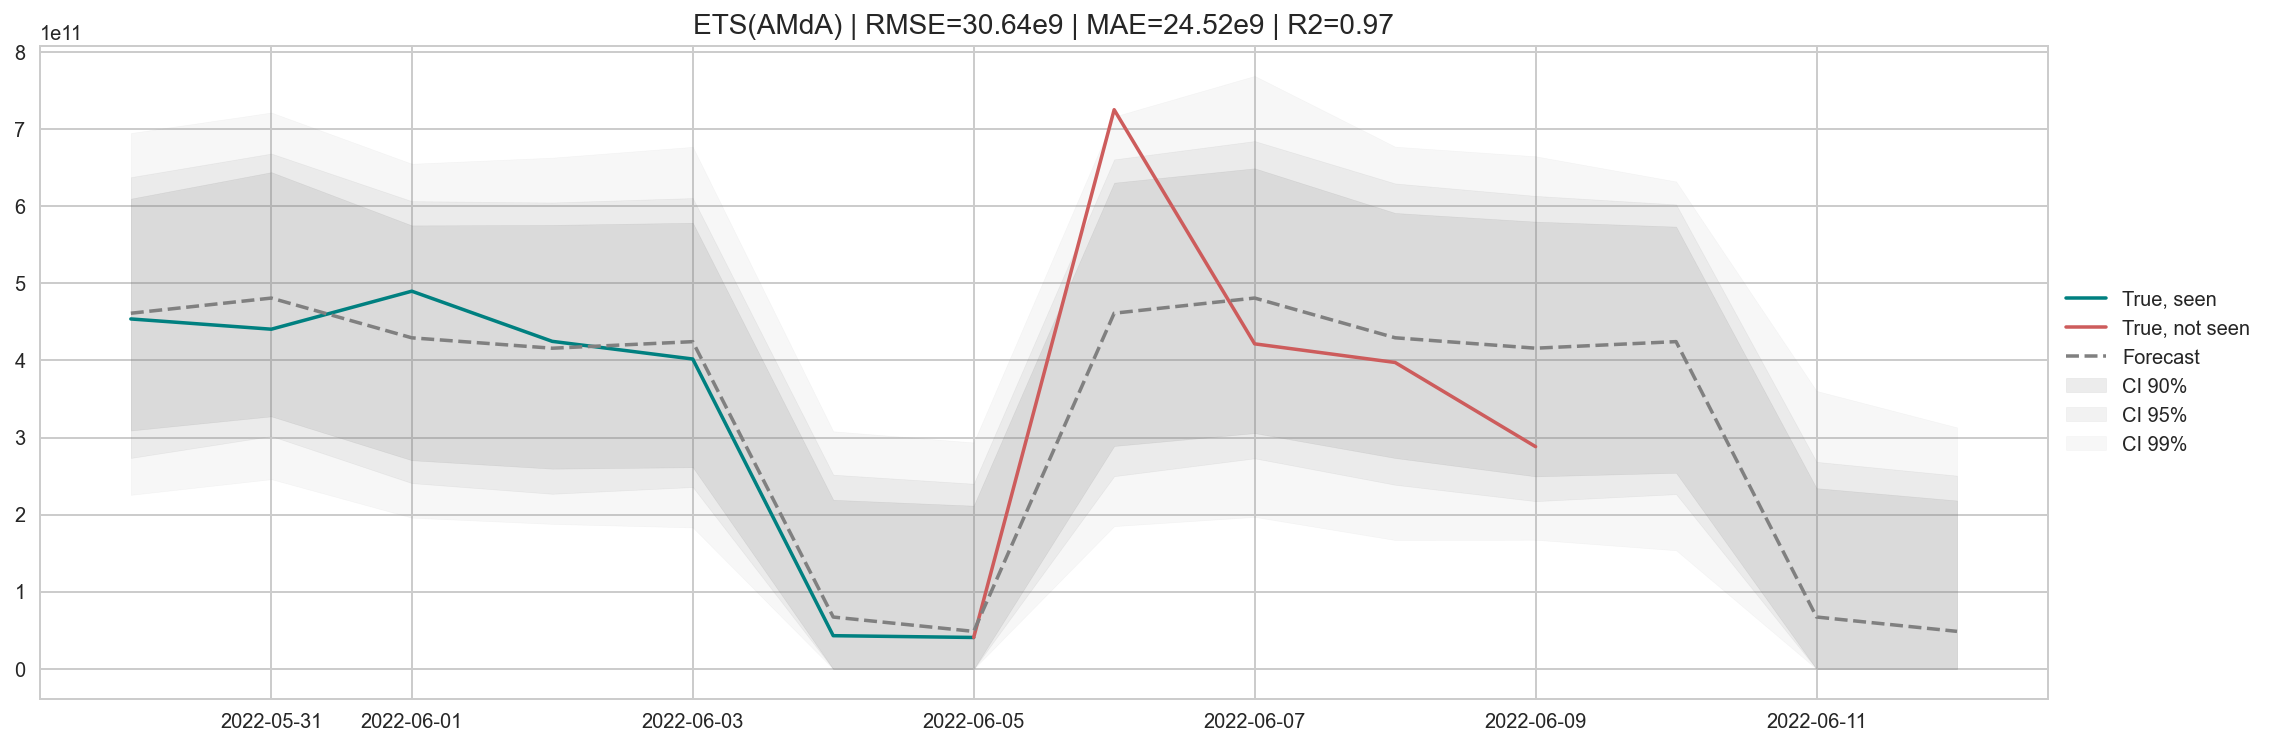

In [223]:
model = AutoForecast(ts=series, estimator='ets', gamma=[0.9, 0.95, 0.99])
model.plot()

0:02:50.968573


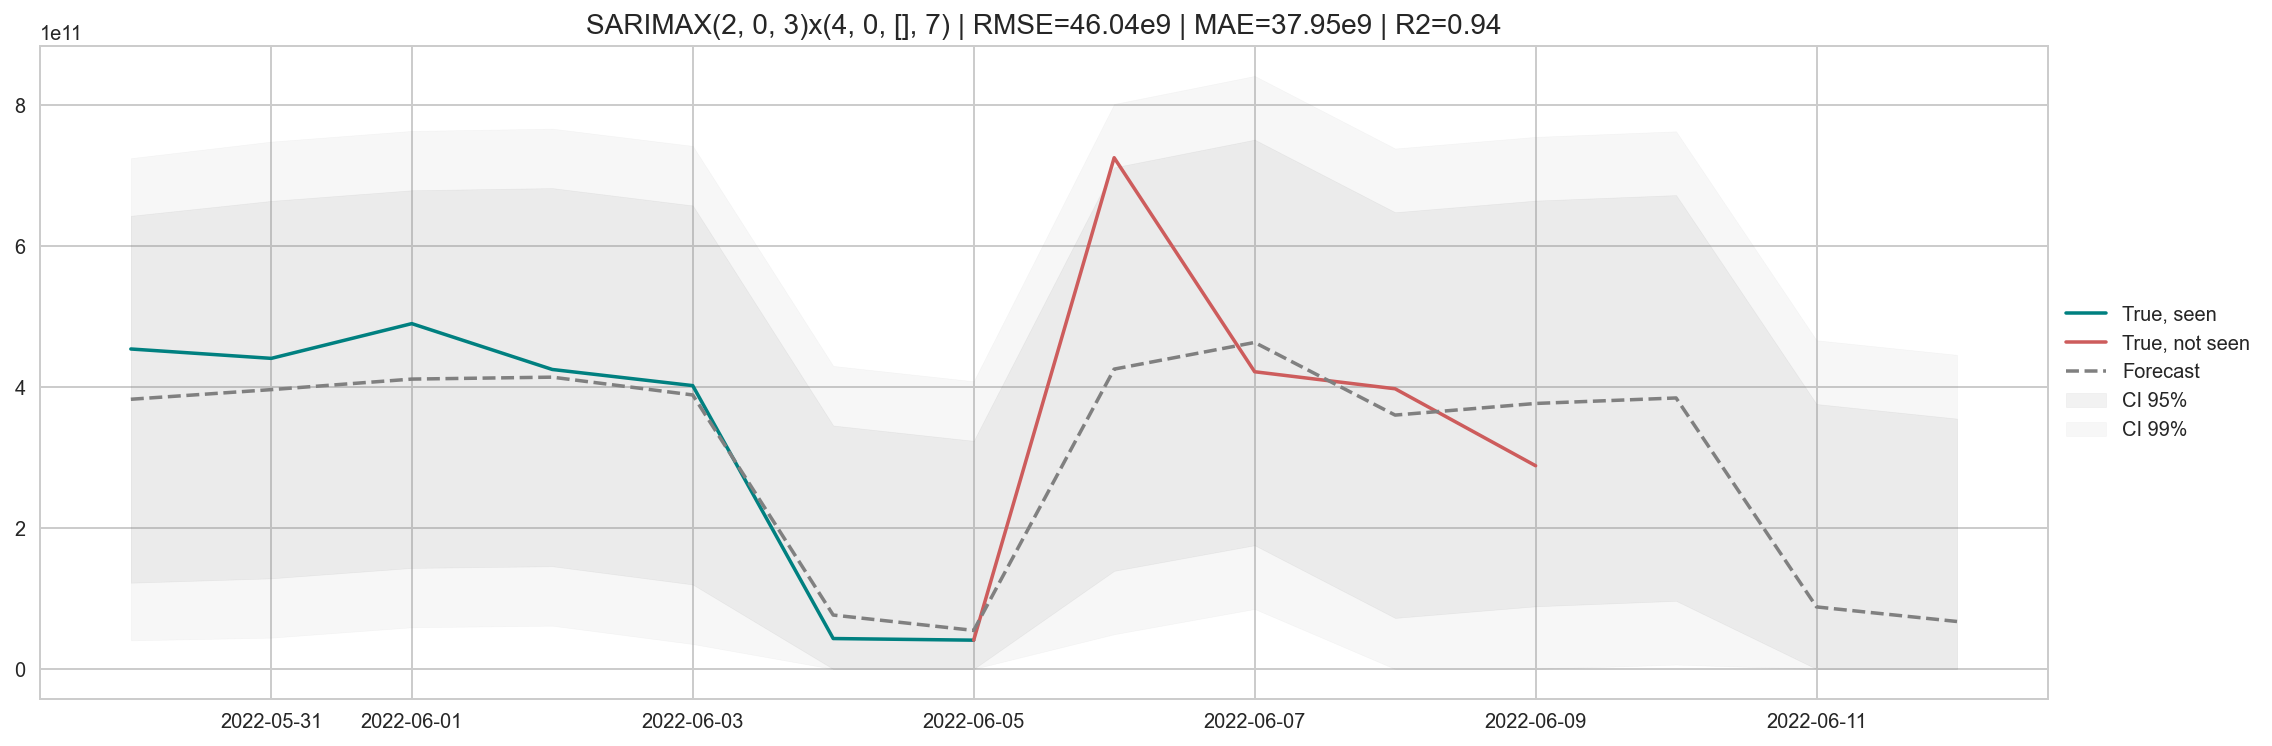

In [205]:
model = AutoForecast(ts=series, estimator='arima')
model.plot()

## 5.2. Last week

0:00:04.680271


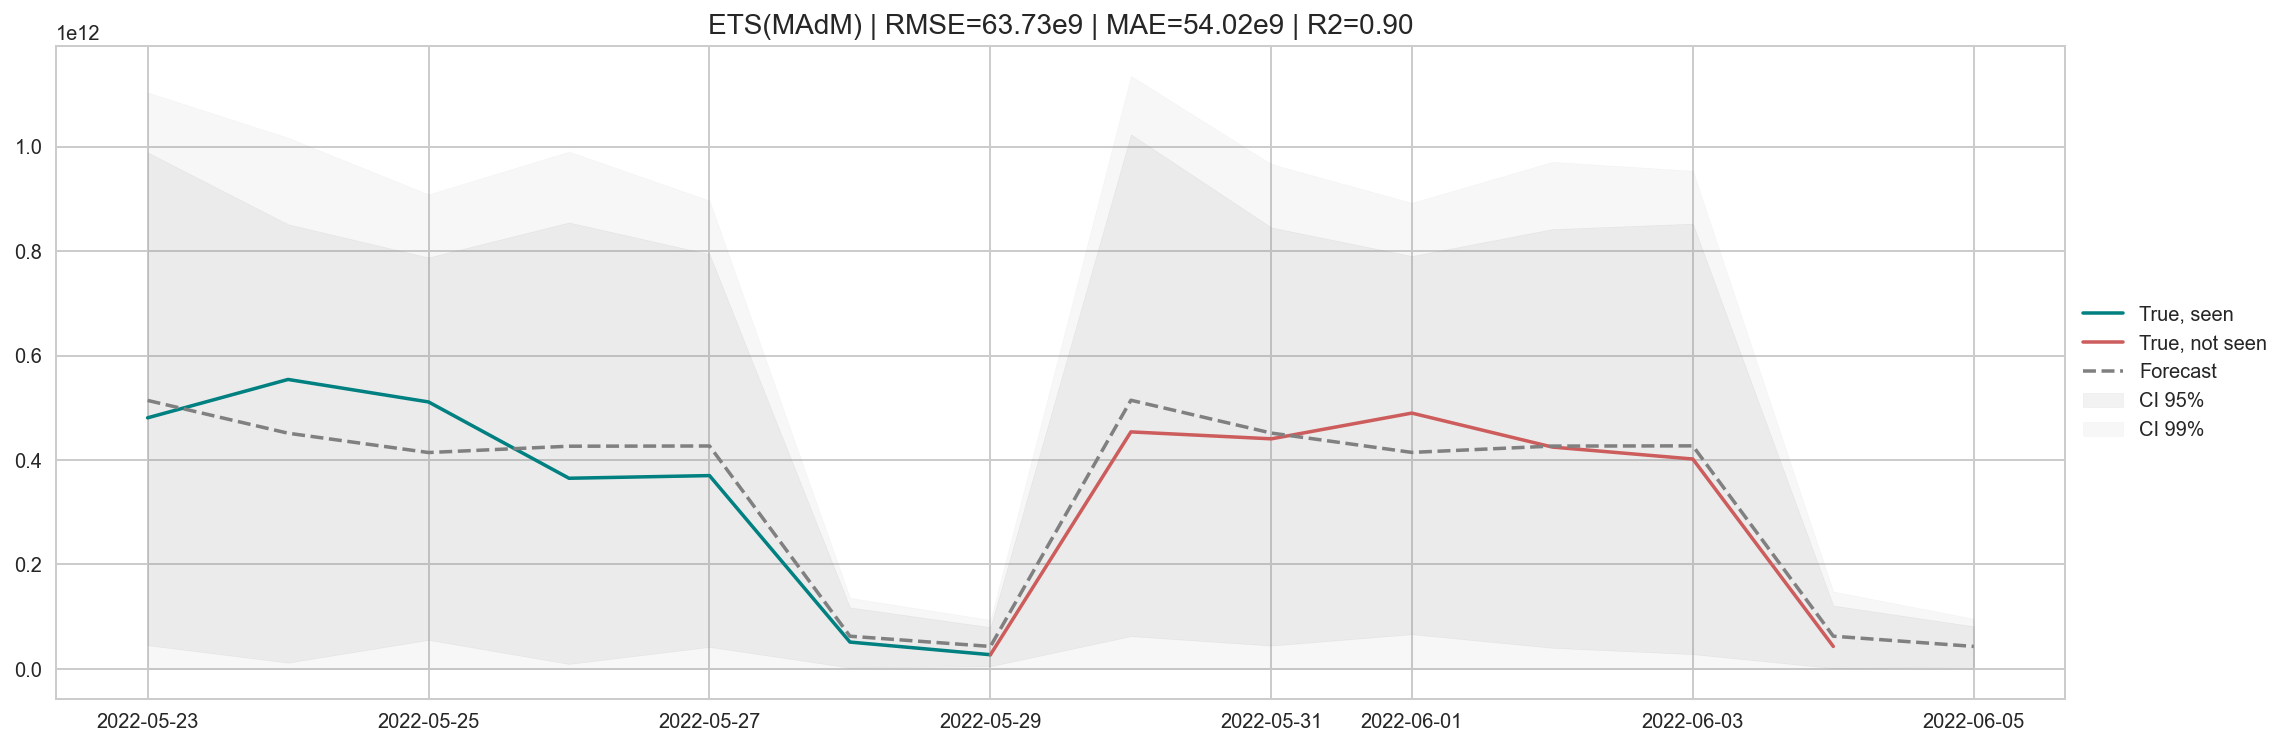

In [206]:
model = AutoForecast(ts=series[:-5], estimator='ets')
model.plot()

0:01:02.696108


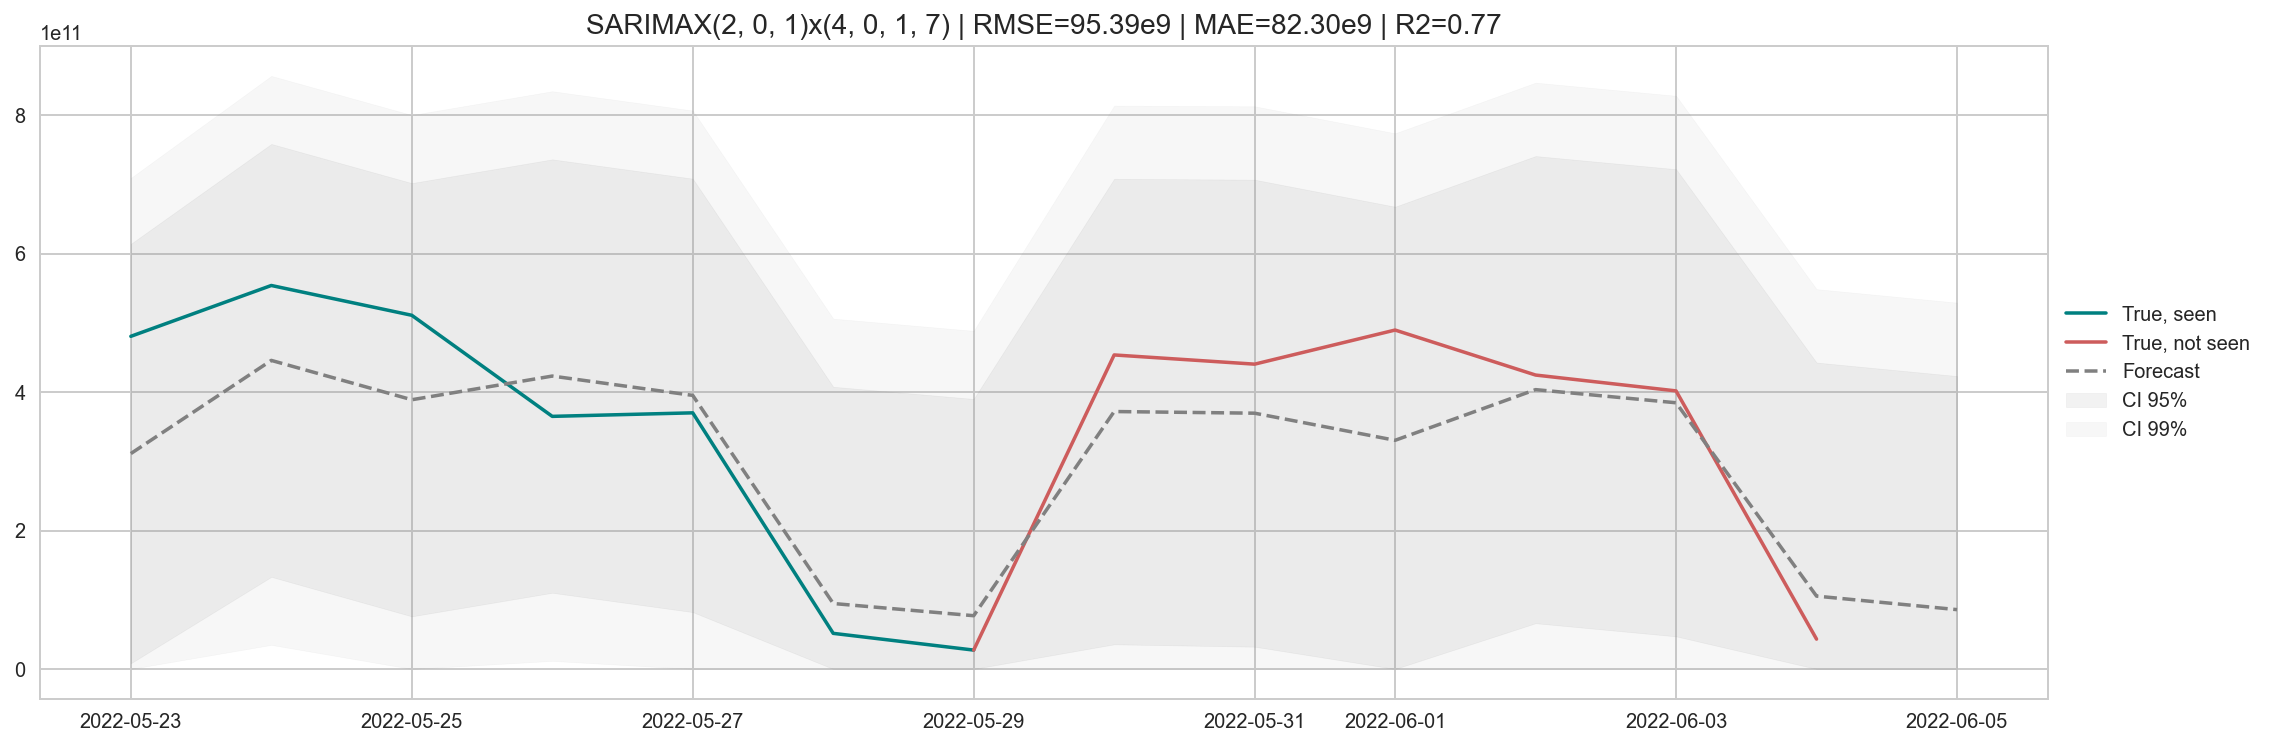

In [207]:
model = AutoForecast(ts=series[:-5], estimator='arima')
model.plot()

## 5.3. May

0:00:03.516348


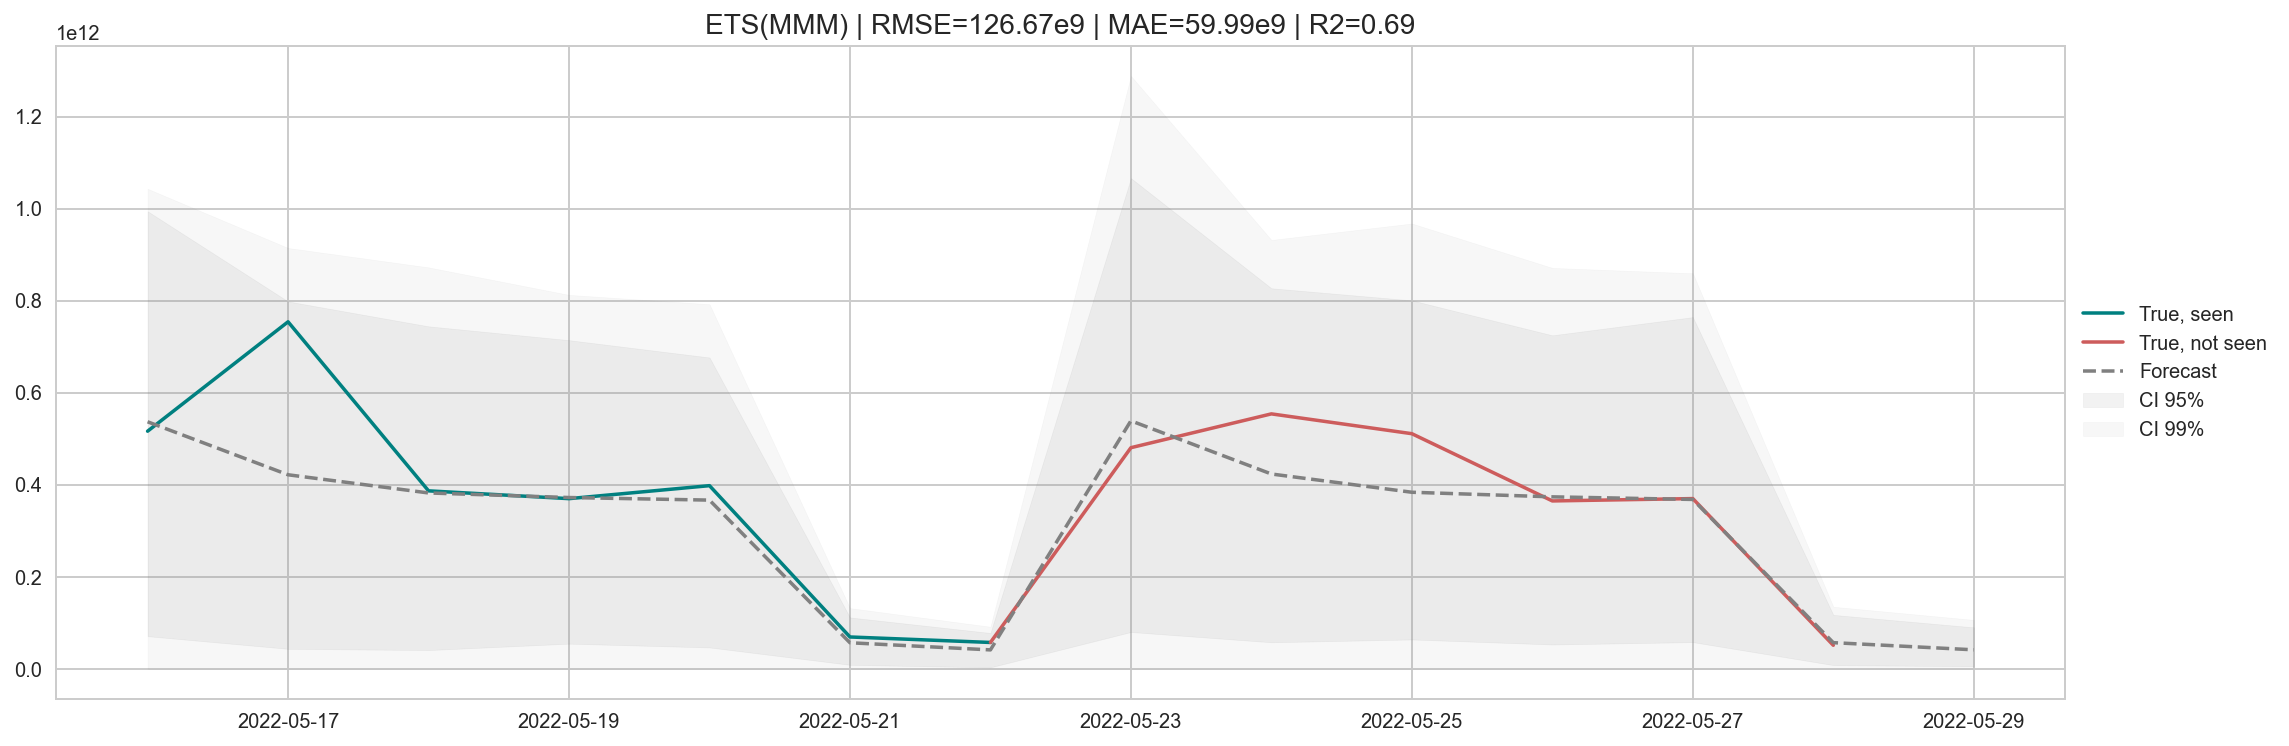

In [209]:
day = '2022-05-28'
model = AutoForecast(ts=series[:day], estimator='ets')
model.plot()

0:00:04.647457


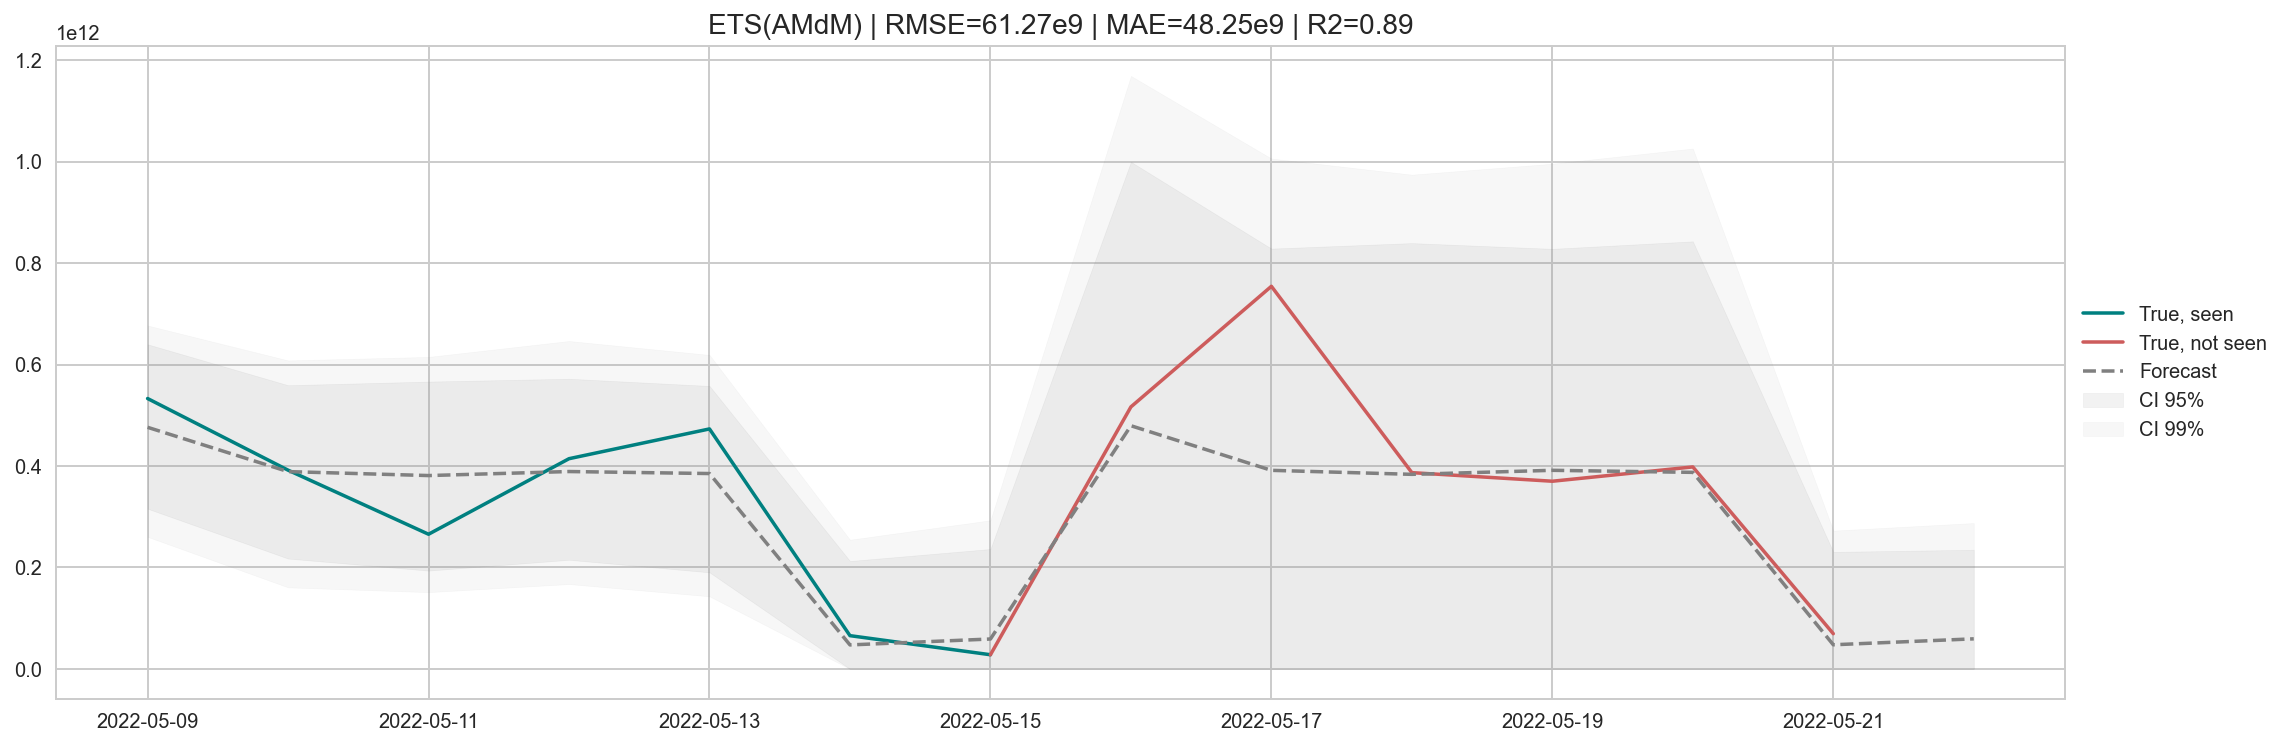

In [210]:
day = '2022-05-21'
model = AutoForecast(ts=series[:day], estimator='ets')
model.plot()

0:00:05.350830


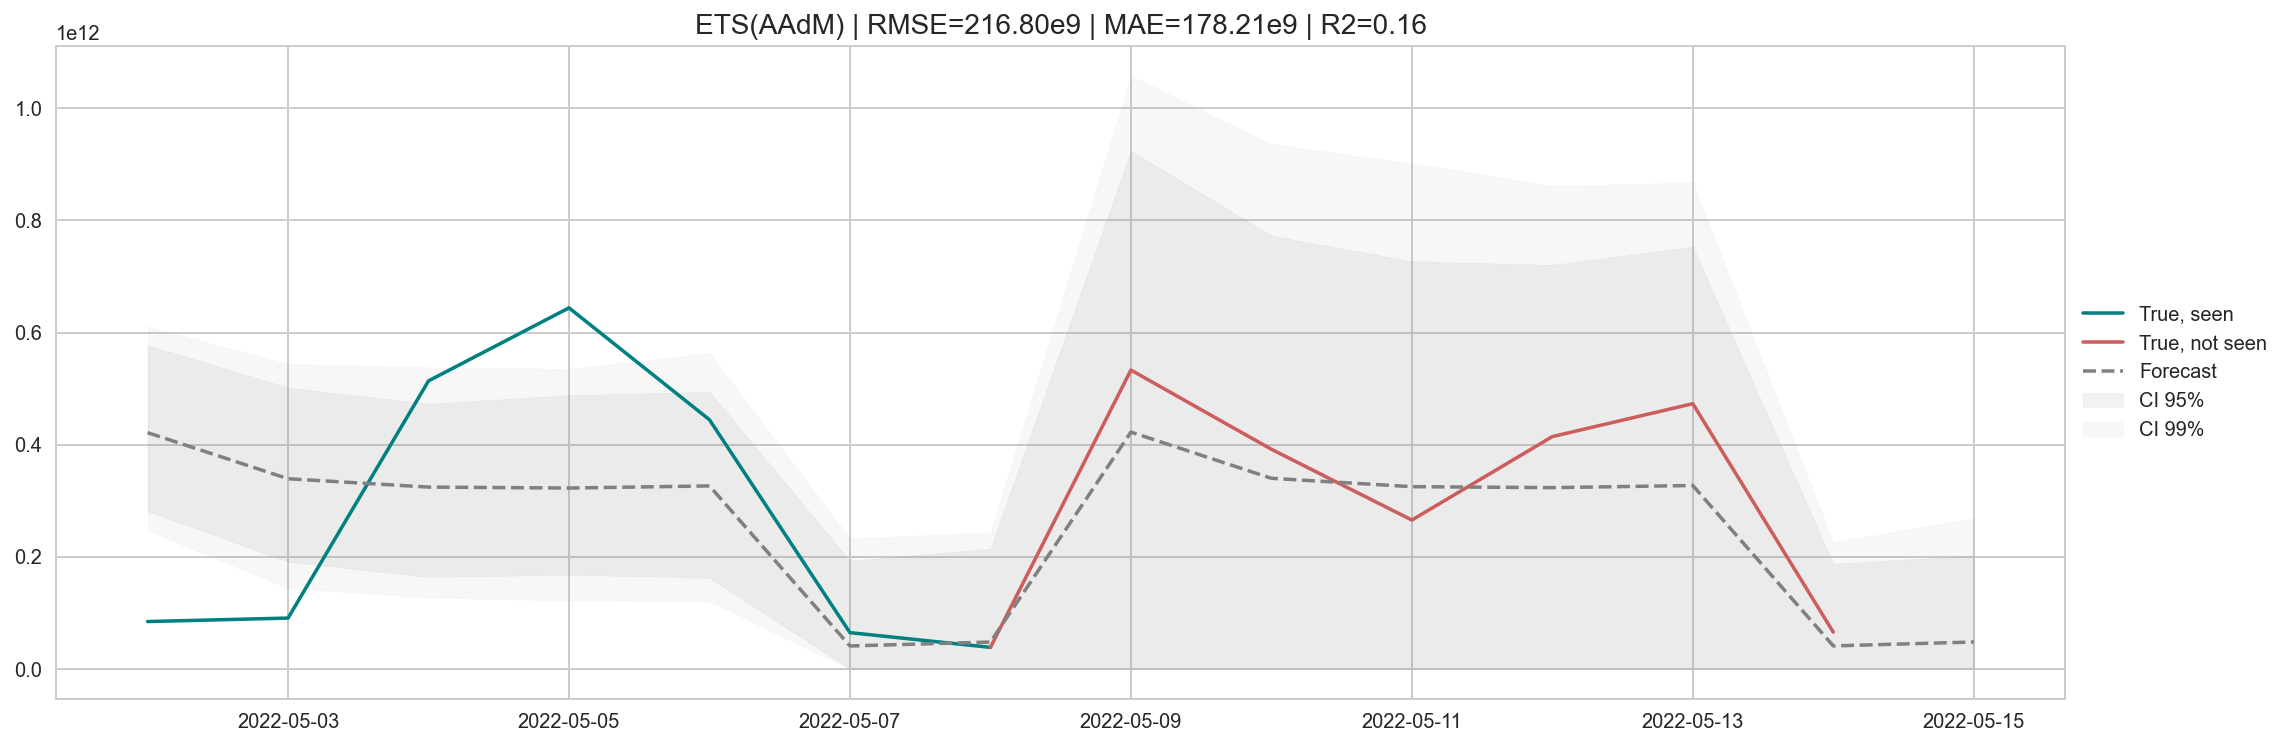

In [211]:
day = '2022-05-14'
model = AutoForecast(ts=series[:day], estimator='ets')
model.plot()

0:00:03.482651


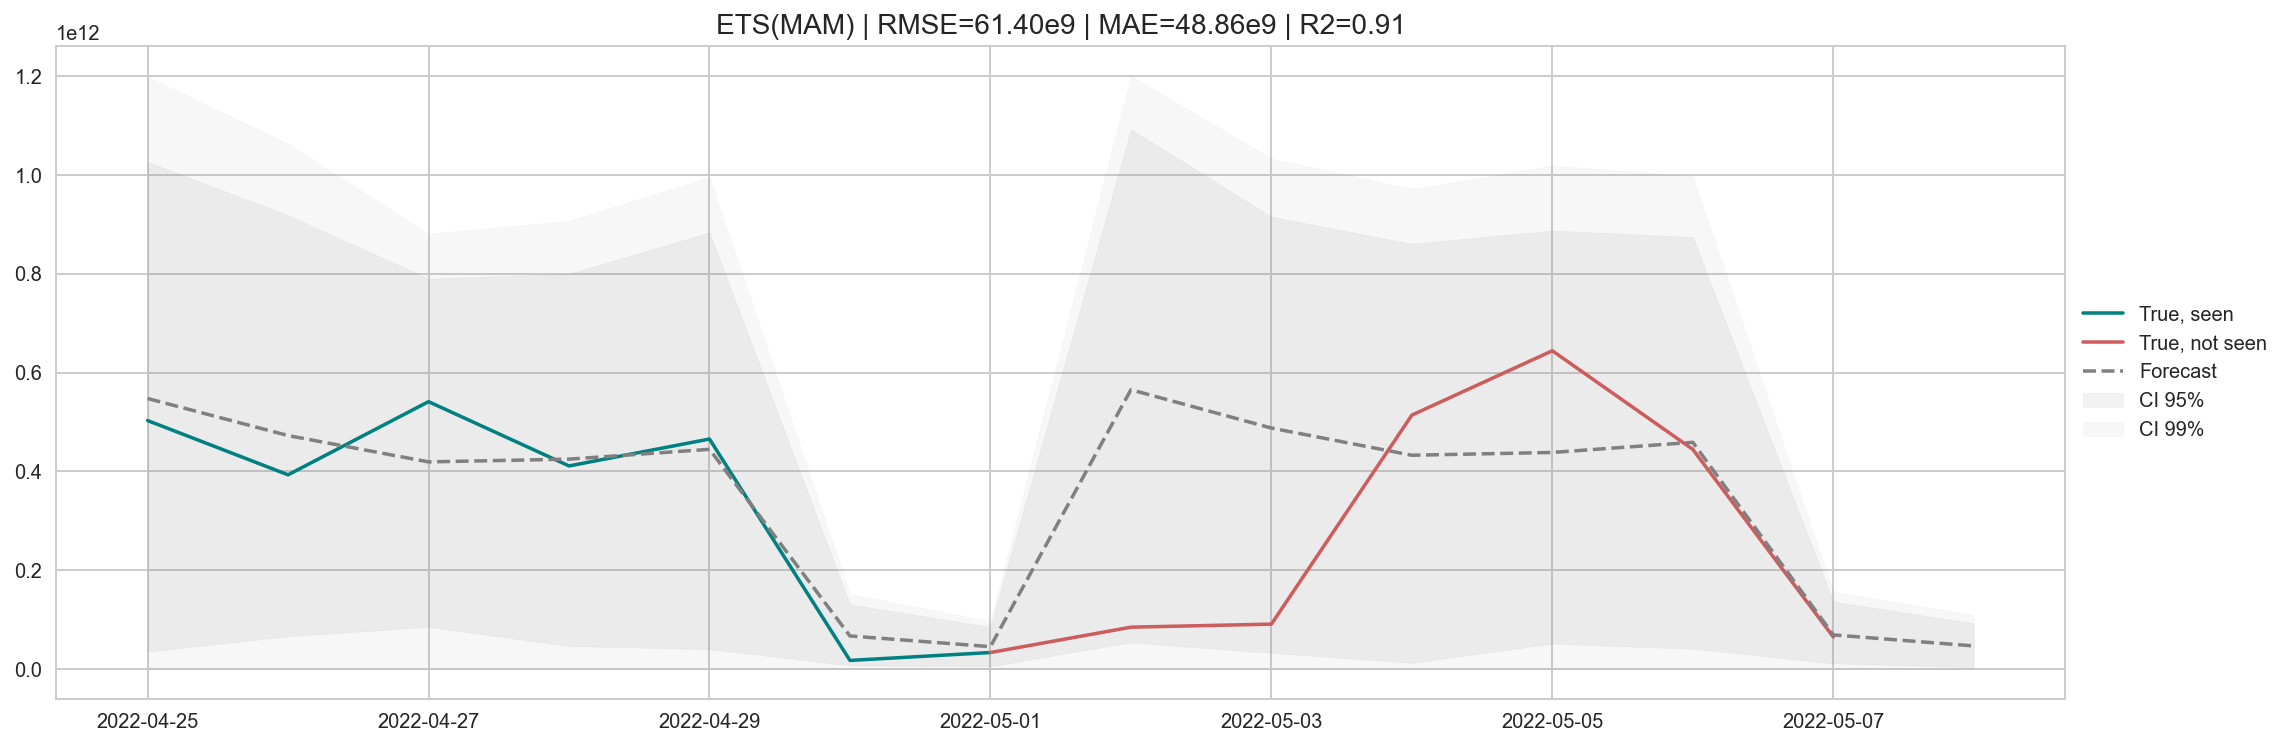

In [212]:
day = '2022-05-07'
model = AutoForecast(ts=series[:day], estimator='ets')
model.plot()

0:01:48.639554


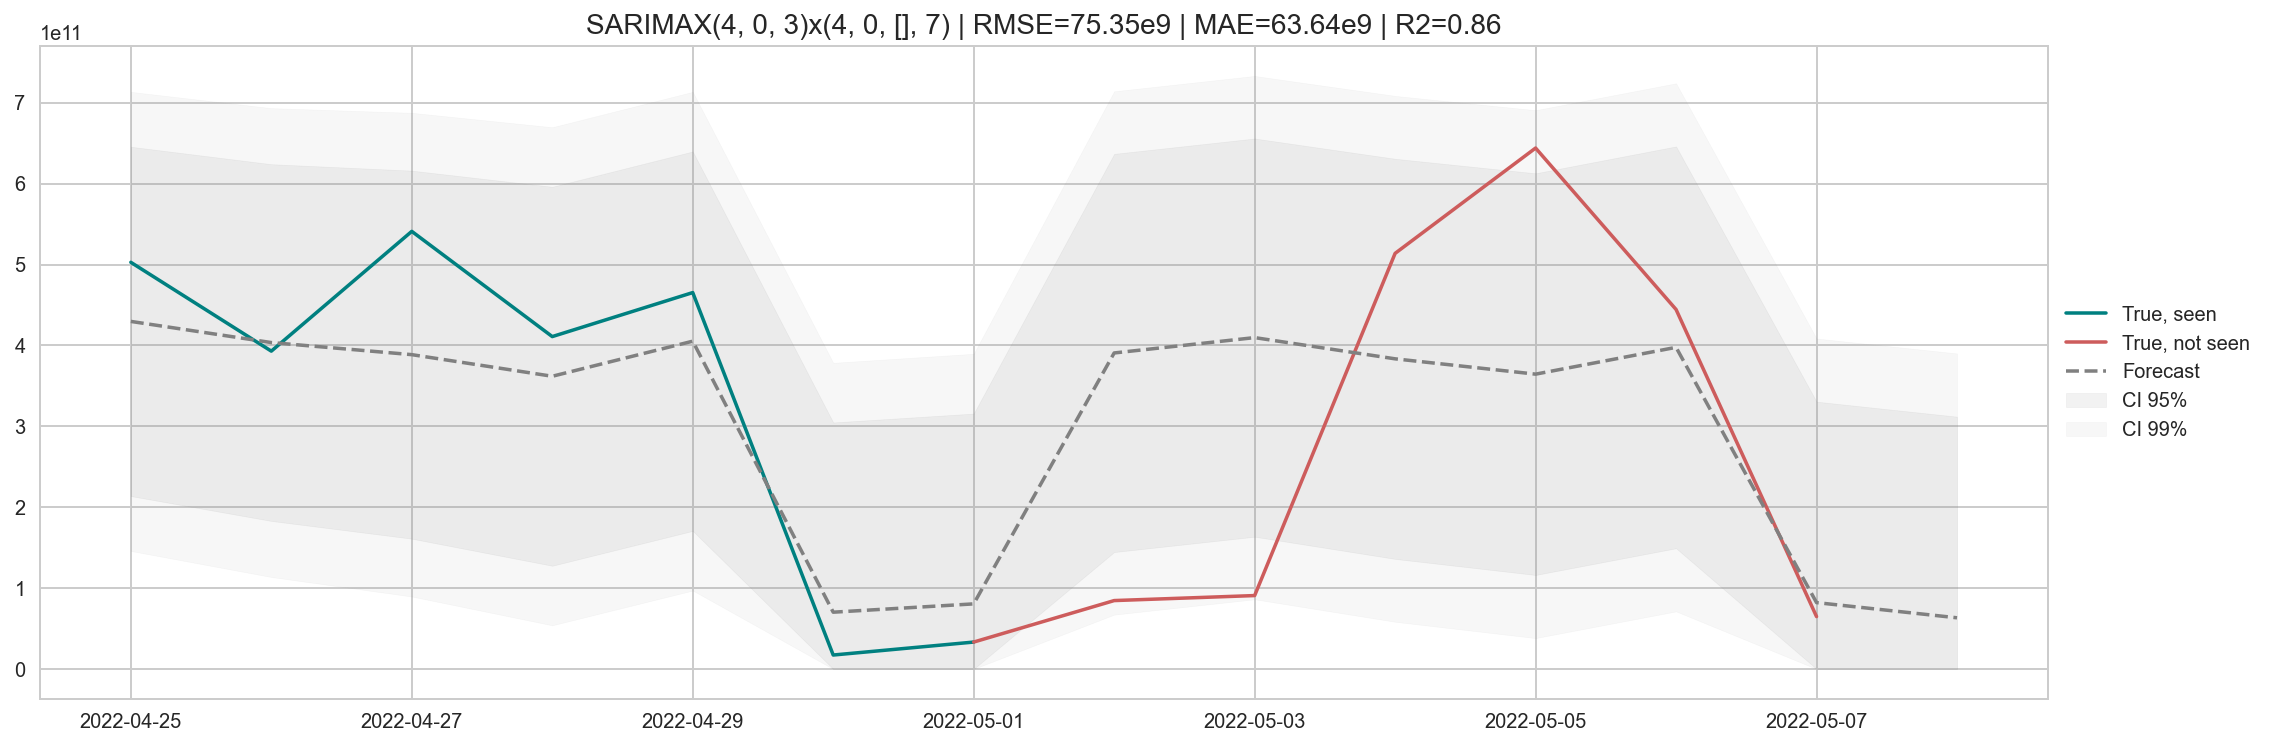

In [217]:
day = '2022-05-07'
model = AutoForecast(ts=series[:day], estimator='arima')
model.plot()

## 5.4. April

0:00:03.773824


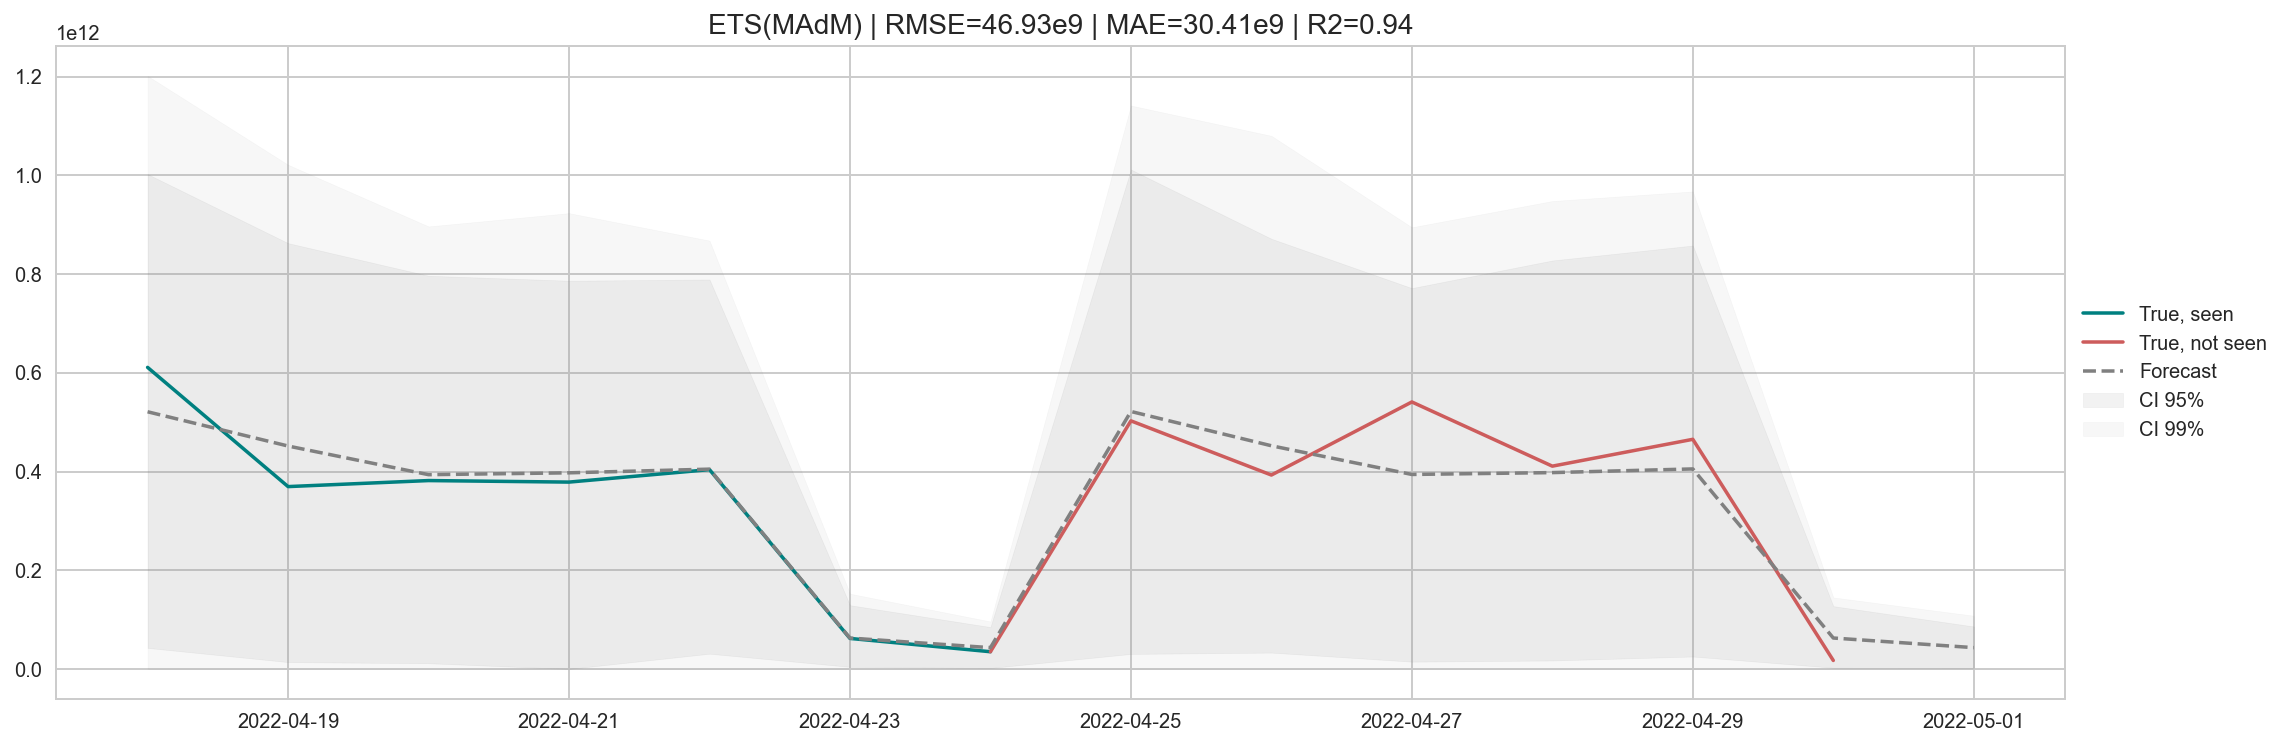

In [213]:
day = '2022-04-30'
model = AutoForecast(ts=series[:day], estimator='ets')
model.plot()

0:00:04.598003


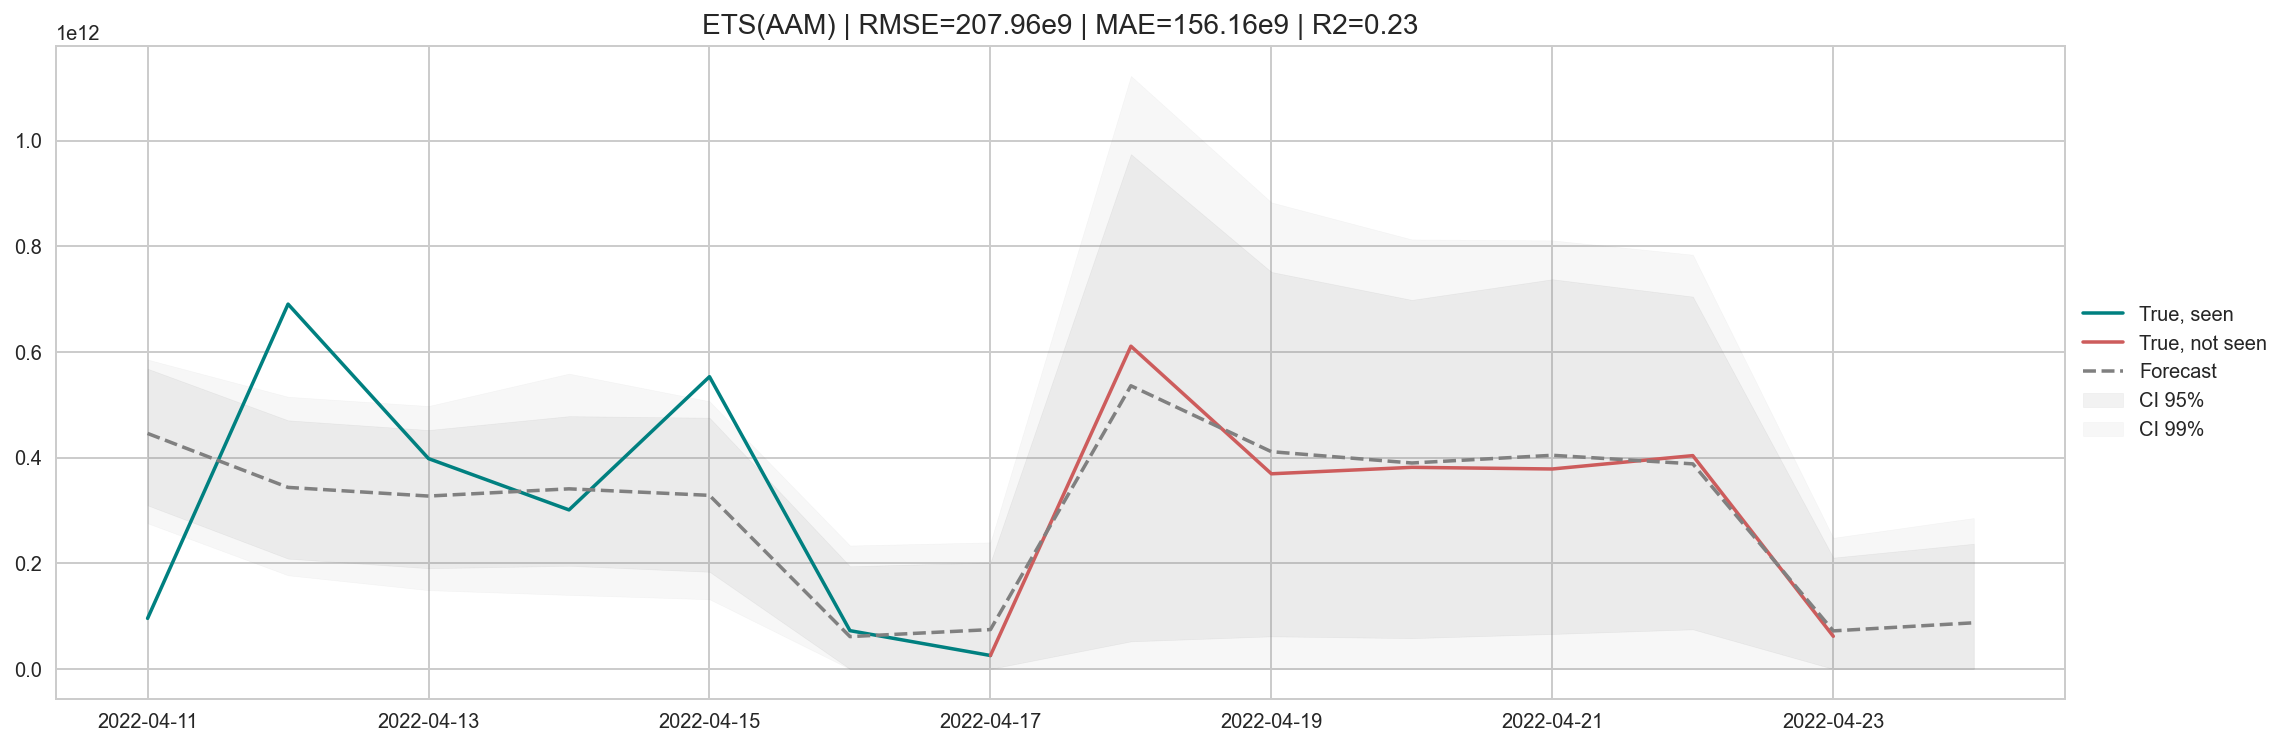

In [214]:
day = '2022-04-23'
model = AutoForecast(ts=series[:day], estimator='ets')
model.plot()

0:00:02.310365


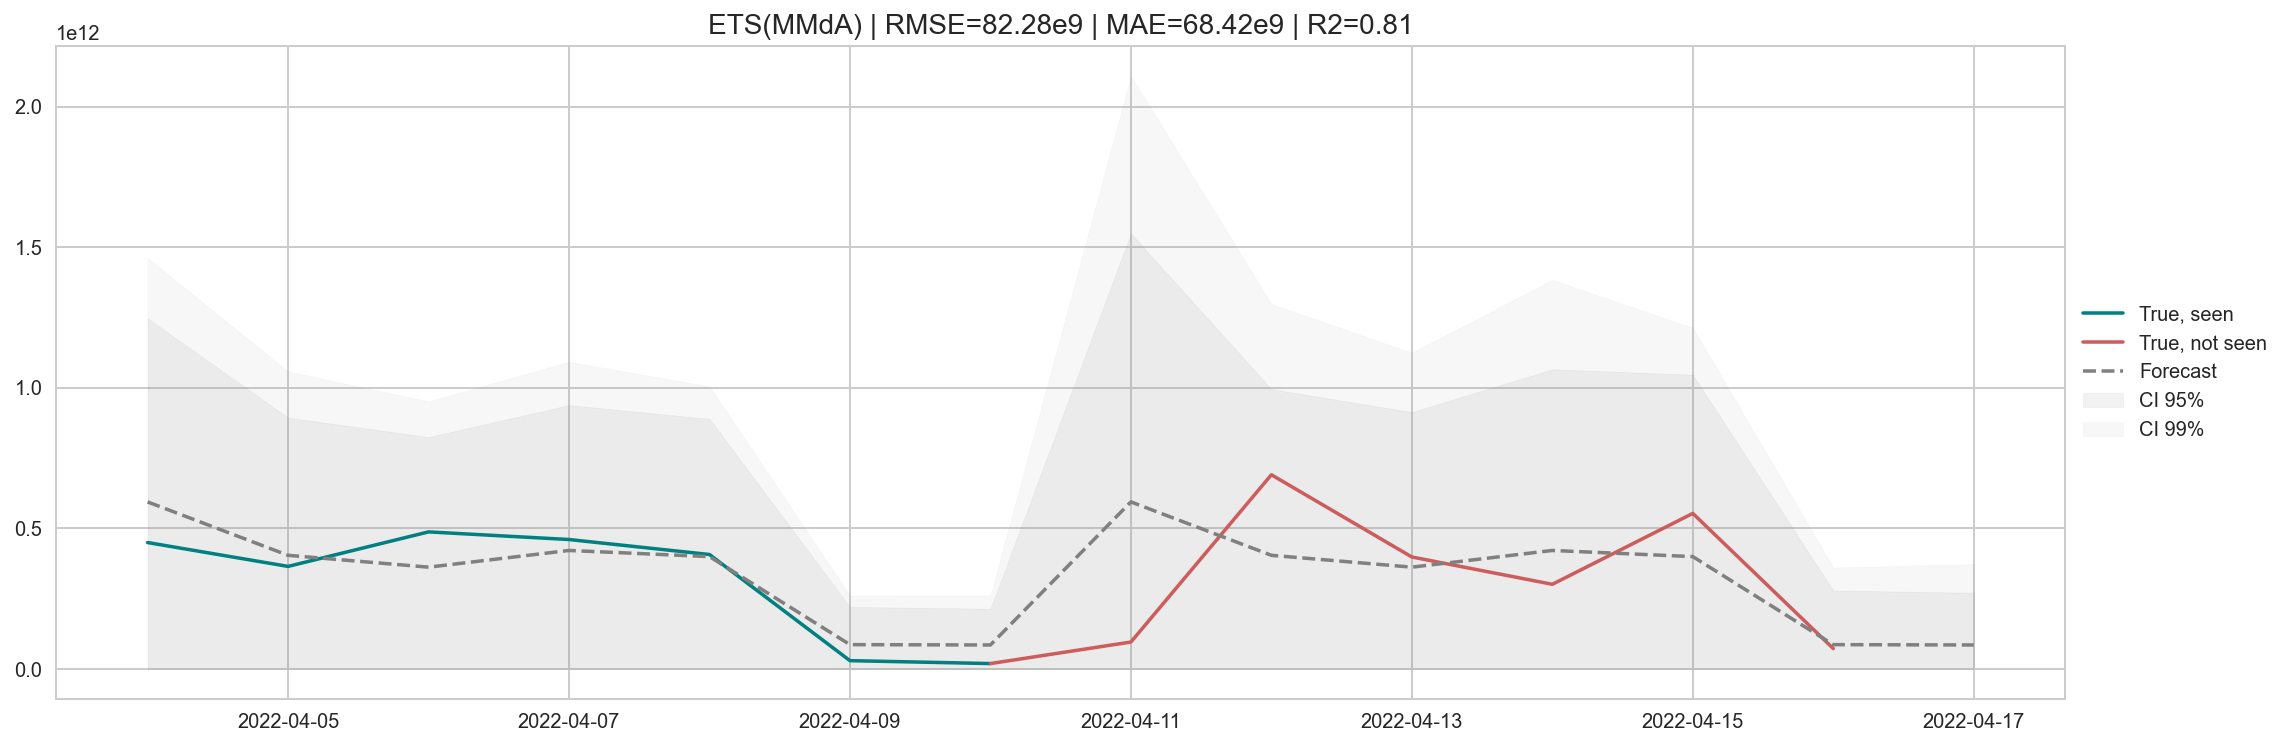

In [215]:
day = '2022-04-16'
model = AutoForecast(ts=series[:day], estimator='ets')
model.plot()

0:00:03.720532


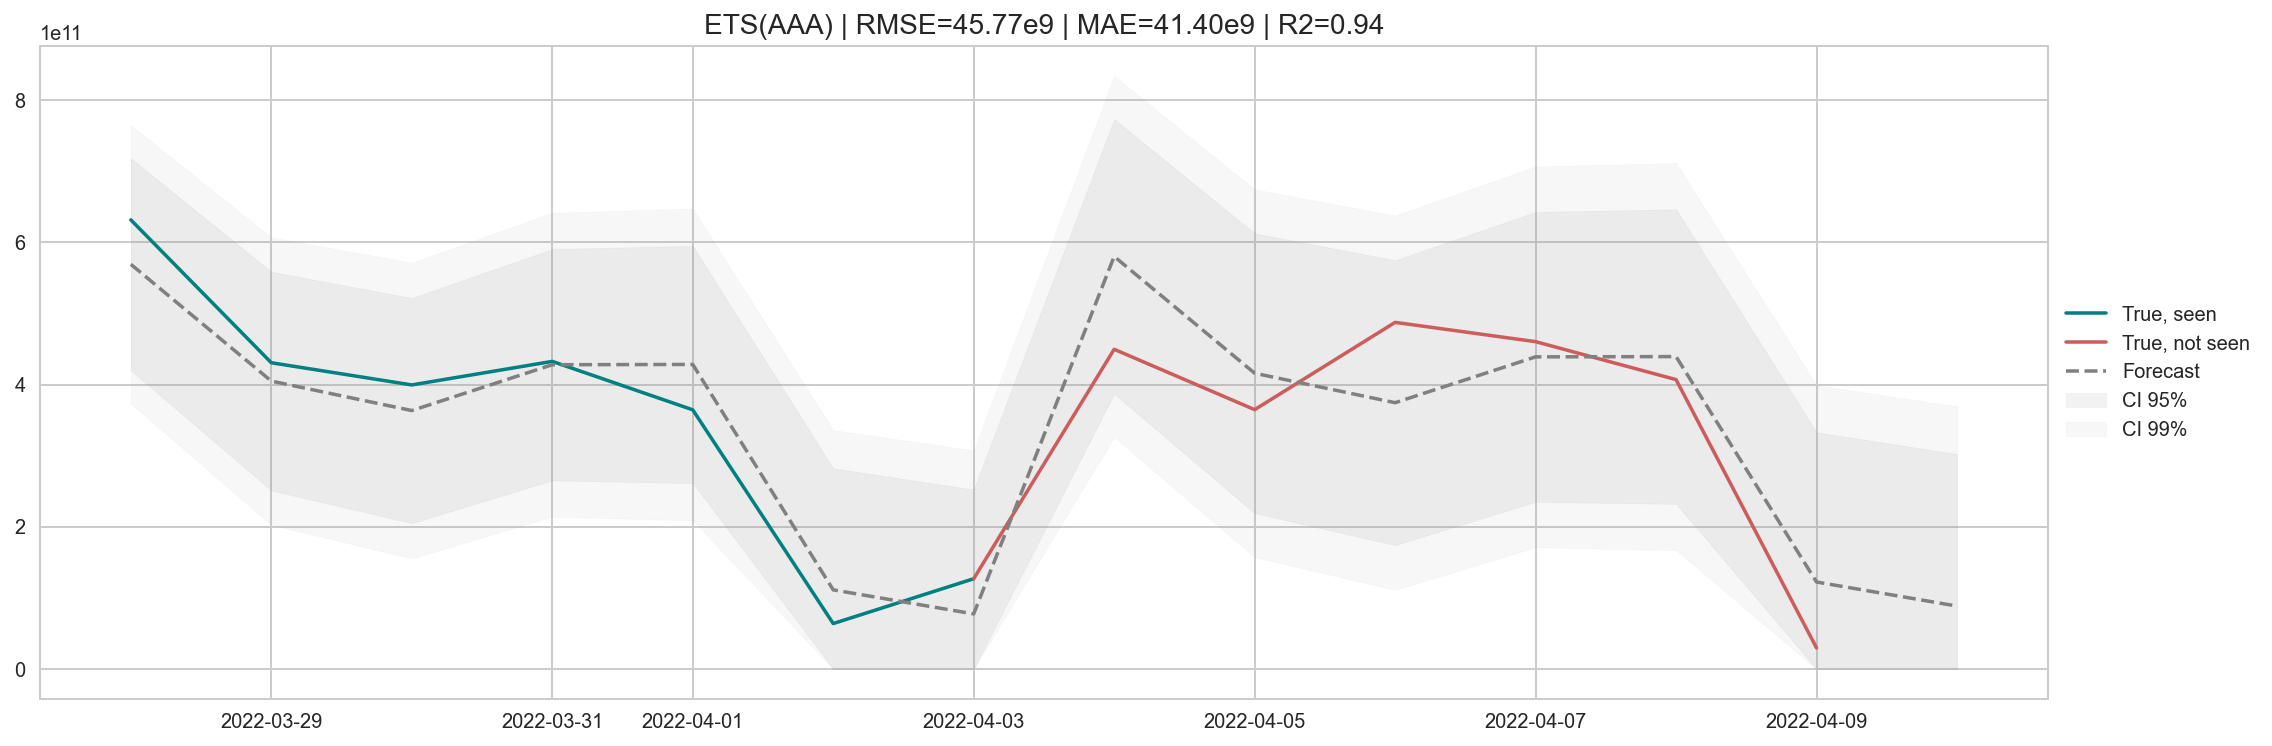

In [216]:
day = '2022-04-09'
model = AutoForecast(ts=series[:day], estimator='ets')
model.plot()

## 5.5. 2019

0:00:02.356416


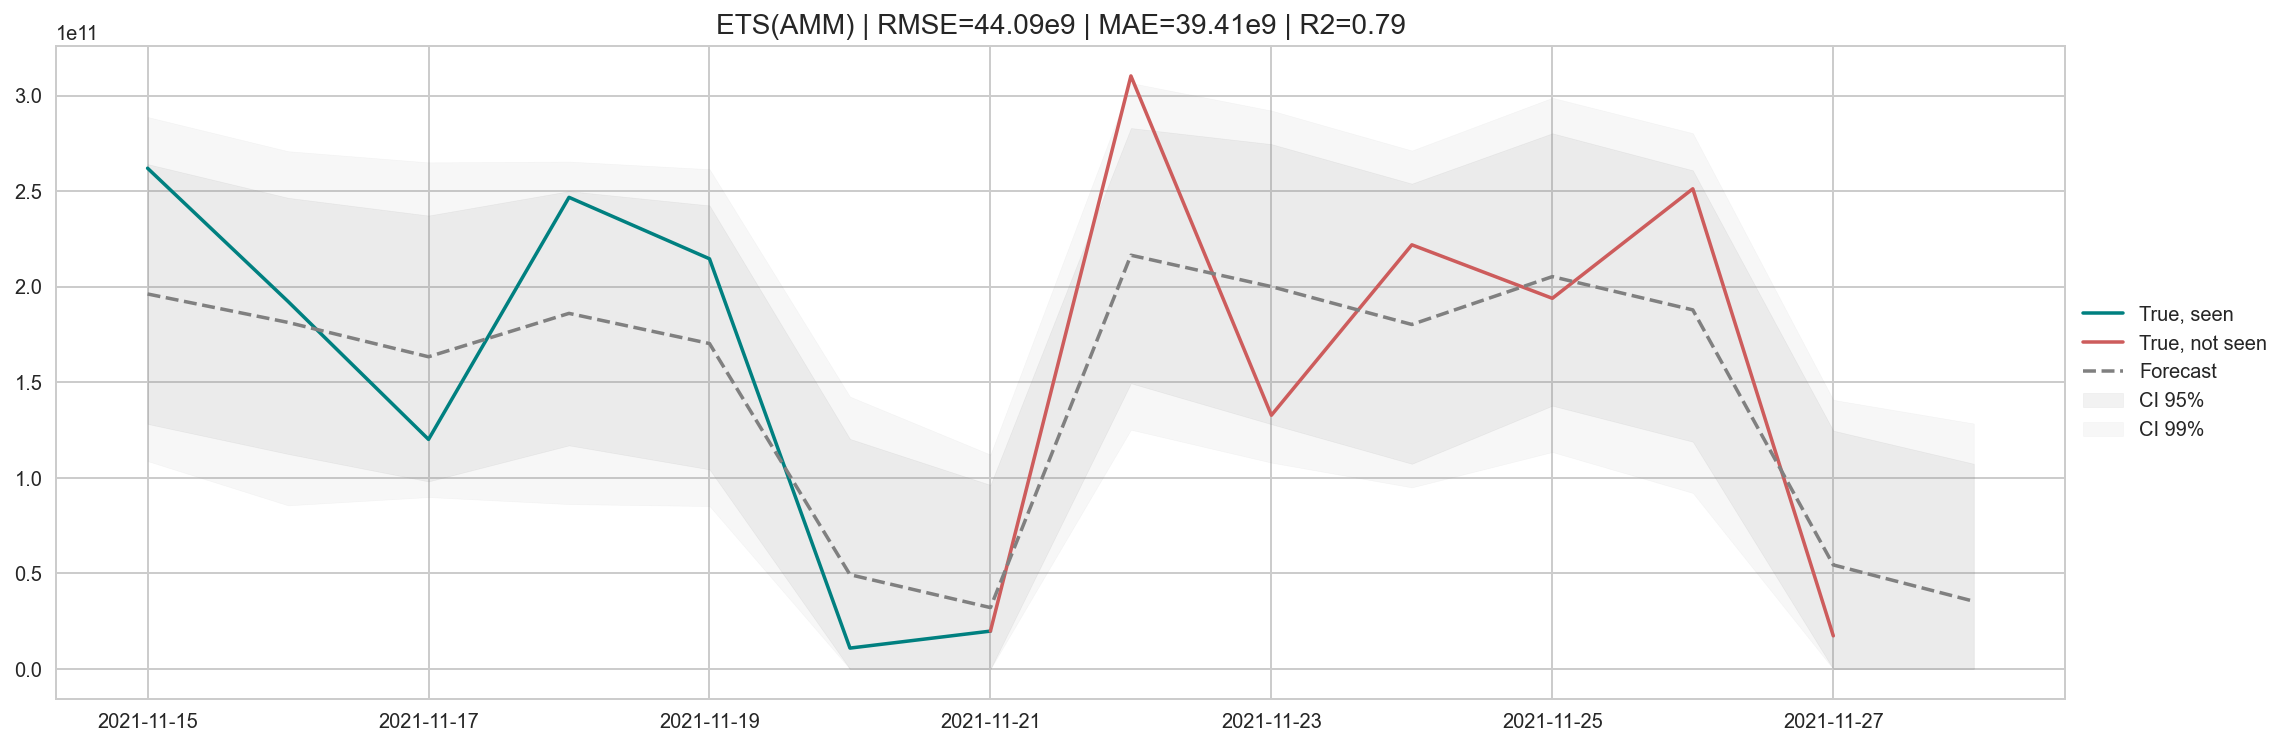

In [224]:
day = '2021-11-27'
model = AutoForecast(ts=series[:day], estimator='ets')
model.plot()

0:00:02.876191


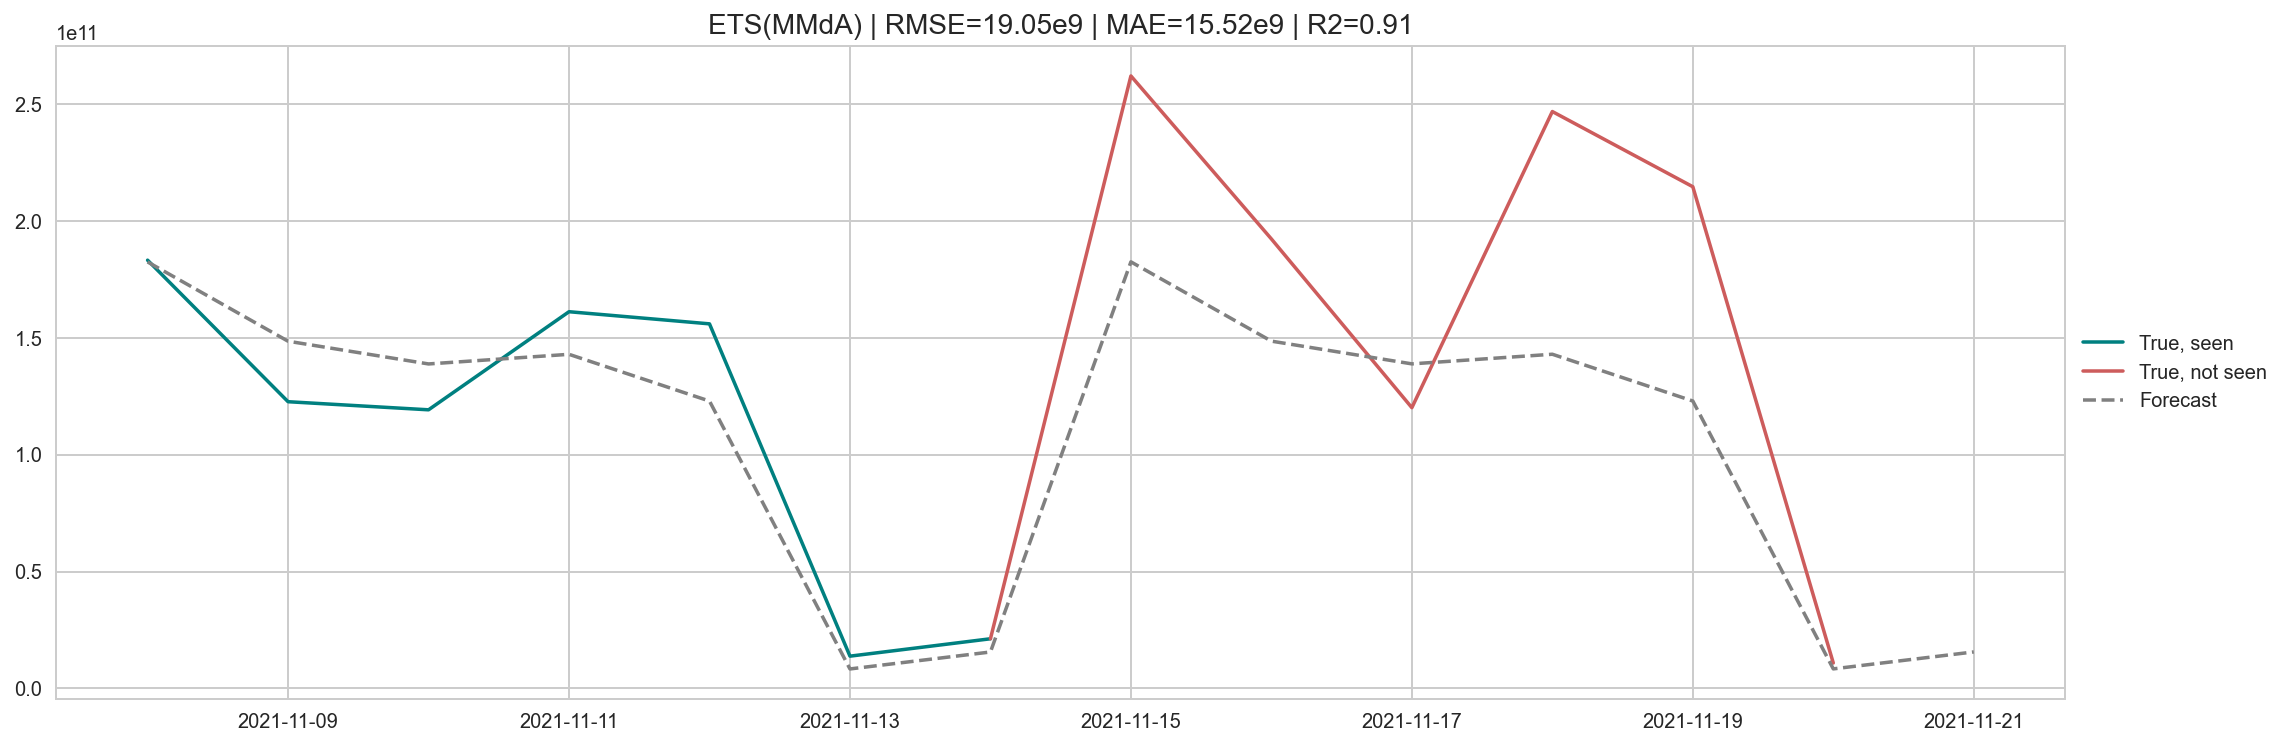

In [233]:
day = '2021-11-20'
model = AutoForecast(ts=series[:day], estimator='ets', gamma=[])
model.plot()

0:00:02.240186


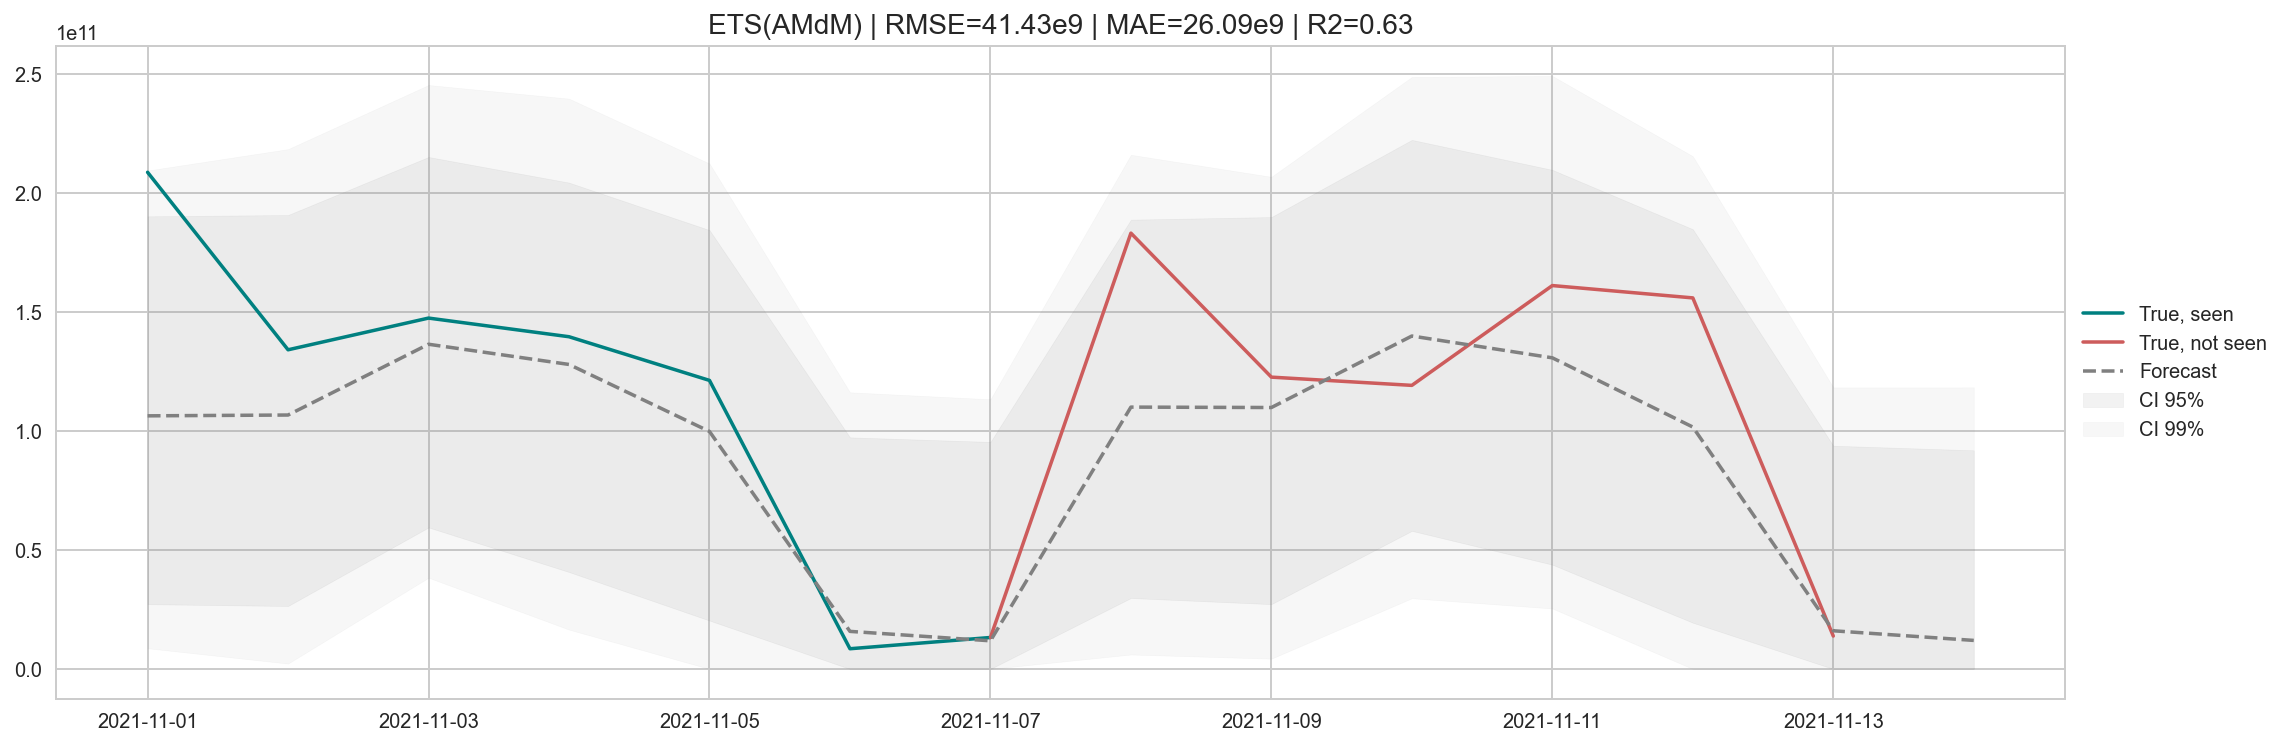

In [230]:
day = '2021-11-13'
model = AutoForecast(ts=series[:day], estimator='ets')
model.plot()

0:00:02.286123


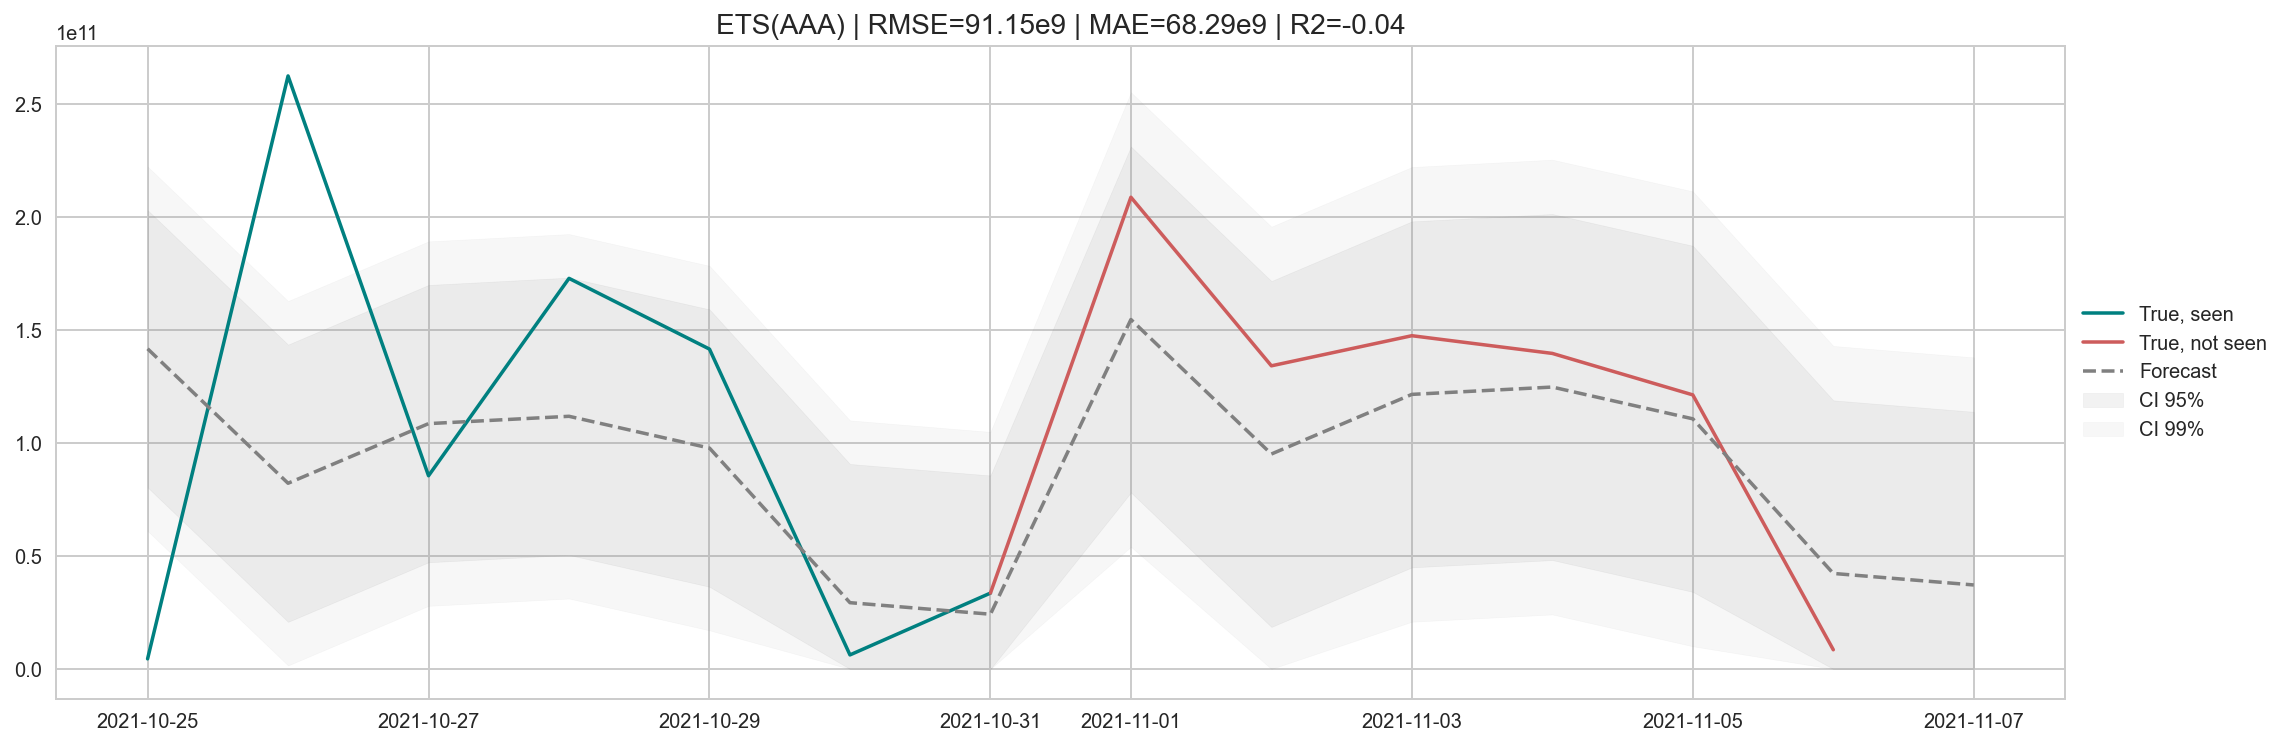

In [234]:
day = '2021-11-06'
model = AutoForecast(ts=series[:day], estimator='ets')
model.plot()

0:00:01.992535


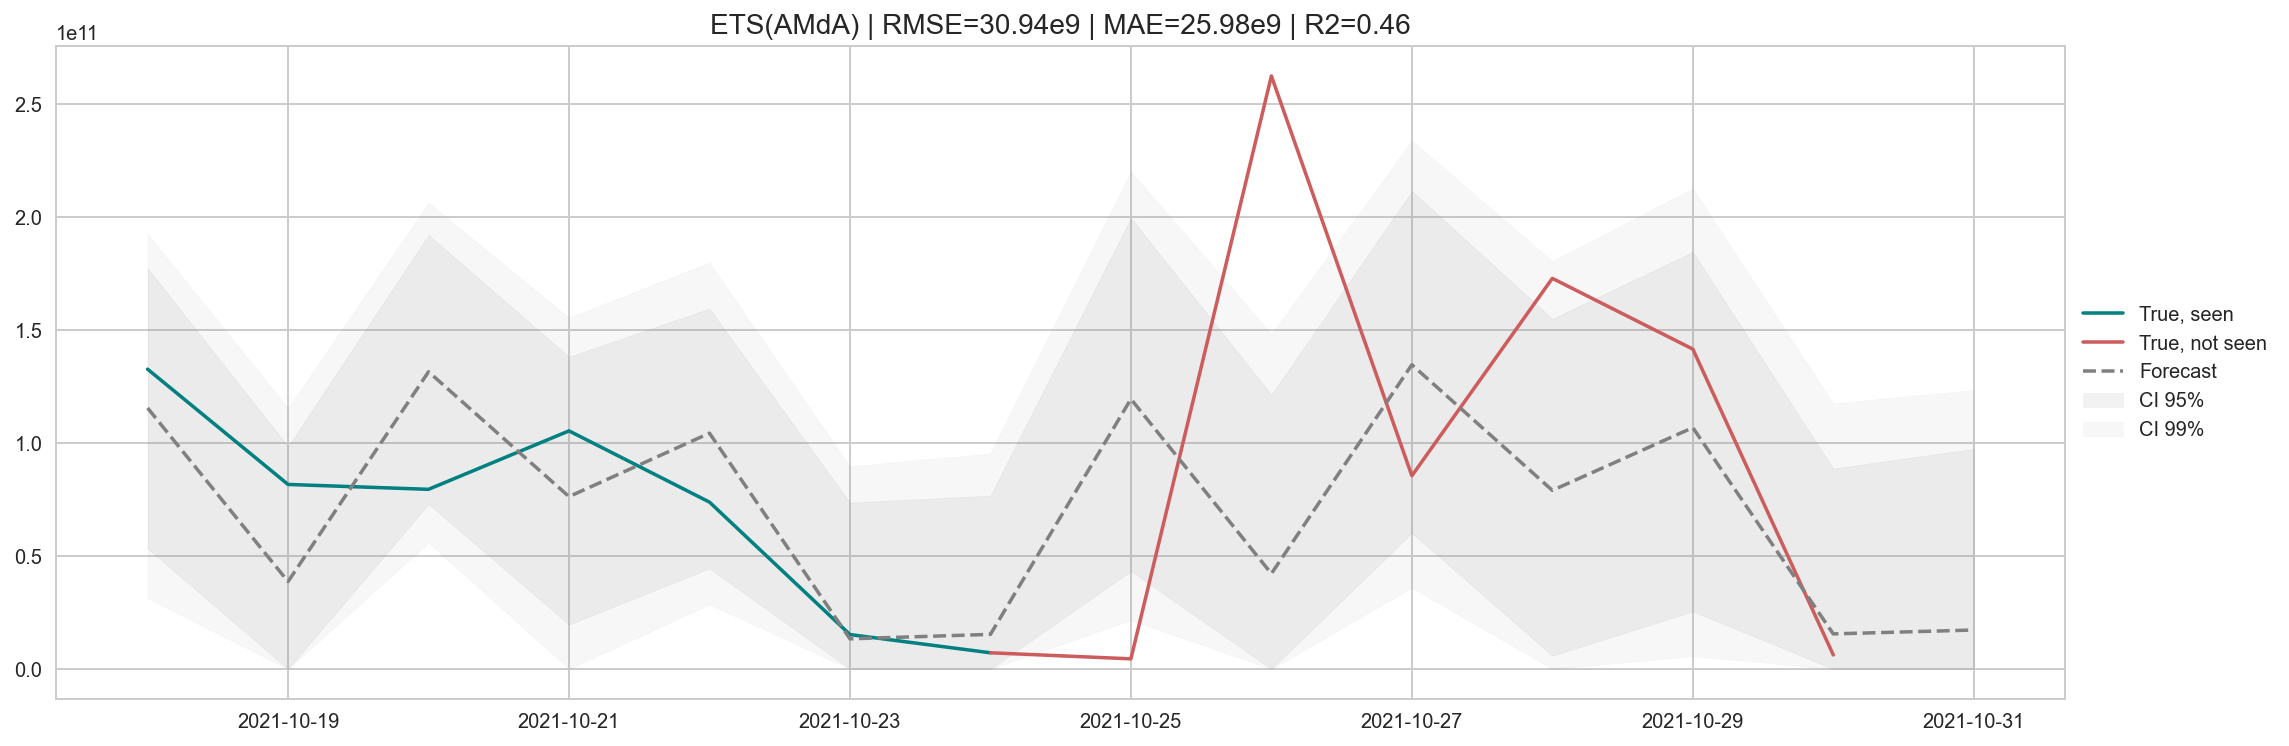

In [235]:
day = '2021-10-30'
model = AutoForecast(ts=series[:day], estimator='ets')
model.plot()